In [1]:
# the class to hande histograms and some helper functions
import copy
import math
import os

def safediv(a,b):
    if float(b) != 0.:
        return a/b
    else:
        return float('nan')
    
def removenan(llist, newv = 0.):
    for i, v in enumerate(llist):
        if math.isnan(v):
            llist[i] = newv
    return llist

def get_histo_from_file_dp(fname,nrebin,obsrange):
    content = open(fname).read()
    xmin = []
    xmax = []
    y = []
    yerr = []
    for l in content.split('\n'):
        values = [float(v) for v in l.split()]
        if not values: continue
        
        if values[0] < obsrange[0] or values[1] > obsrange[1]: continue
        xmin.append(values[0])
        xmax.append(values[1])
        y.append(values[2])
        yerr.append(0.)
        
    return Histogram(xmin, xmax, y, yerr).rebin(nrebin)


def get_histo_from_file(fname, hname, htype, nrebin=1, fixrate=False, totrate=0., scvarfiles = []):
    content = open(fname).read()
    found = False
    xmin = []
    xmax = []
    y = []
    yerr = []
    scvars = {0.5:[], 2.:[]}
    
    for l in content.split('\n'):

        if l.startswith("<histogram>") and l.split('"')[1].strip().startswith(hname) and \
        ('TYPE@%s|' % htype in l or 'TYPE@%s"' % htype in l or '|T@%s ' % htype in l):
            found = True
            continue
        if found and l.startswith("<\\histogram>"):
            break
        if found:
            values = [float(v) for v in l.split()]
            xmin.append(values[0])
            xmax.append(values[1])
            y.append(values[2])
            yerr.append(values[3])
            if not scvarfiles and len(values) == 16:
                scvars[0.5].append(values[15])
                scvars[2.].append(values[12])
            elif scvarfiles:
                scvars[0.5] = get_histo_from_file(scvarfiles[0], hname, htype, nrebin, fixrate, totrate)['y']
                scvars[2] = get_histo_from_file(scvarfiles[1], hname, htype, nrebin, fixrate, totrate)['y']


    if not found:
        print('Not found, ', fname, hname, htype)
        raise HistoNotFound('get_histo_from_file, not found', fname, hname, htype)
    return Histogram(xmin, xmax, y, yerr, scvars, fixrate, totrate).rebin(nrebin)


def get_histo_from_datfile(fname, nevents=1., nrebin=1):
    content = open(fname).read()
    xmin = []
    xmax = []
    y = []
    yerr = []
    
    for l in content.split('\n'):
        if not(l): continue
        if l.startswith('#') or l.strip().startswith('No'): continue
        values = [float(v) for v in l.split()]
        xmin.append(values[0])
        xmax.append(values[1])
        y.append(values[2]/nevents)
        if values[3] != 0:
            yerr.append(values[2]/math.sqrt(values[3])/nevents)
        else:
            yerr.append(0)

    return Histogram(xmin, xmax, y, yerr).rebin(nrebin)
            
class HistoNotFound(Exception):
    pass

class Histogram(dict):
    def __init__(self, xmin, xmax, y, yerr, scvars = {}, fixrate=False, rate=0.):
        if not (len(xmin)==len(xmax)==len(y)==len(yerr)):
            raise Exception('Init, Invalid size')
                
        self['xmin'] = xmin
        self['xmax'] = xmax
        self['x'] = [(x1+x2)/2 for x1,x2 in zip(xmin,xmax)]
        self['xlo'] = xmin
        self['xhi'] = xmax
        self['y'] = y
        self['yerr'] = yerr
        self['nbins'] = len(xmin)
        self['scvars'] = scvars
        
        if fixrate:
            # this is for mtt, with issues related to overflow in the last bin
            # change the rate of the last bin so that the total rate of
            # the histogram is equal to rate
            self['y'][-1] += rate - self.totrate
                
    
    def __add__(self, other):
        if type(other) == Histogram:
            if not (len(self['y']) == len(other['y'])):
                raise Exception('add, Invalid size')
            if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
                raise Exception('add, Invalid x')
            if self['scvars'] and other['scvars']:
                scvars = dict([(k,[v1+v2 for v1,v2 in zip(self['scvars'][k],other['scvars'][k])]) for k in self['scvars'].keys() ])
            else:
                scvars = {}
            return Histogram(self['xmin'], self['xmax'],
                        [y1+y2 for y1,y2 in zip(self['y'], other['y'])],
                        [math.sqrt(y1**2+y2**2) for y1,y2 in zip(self['yerr'], other['yerr'])],
                        scvars = scvars)
        elif type(other) in [int, float]:
            return Histogram(self['xmin'], self['xmax'],
                        [y1+other for y1 in self['y']],
                        self['yerr'],
                        scvars = dict([(k,[v+other for v in self['scvars'][k]]) for k in self['scvars'].keys() ]))
        else:
            raise(Exception, 'invalid type %s' % type(other))
            
    
    def __sub__(self, other):
        return self + (other * (-1))
    
    
    
    def __mul__(self, other):
        if type(other) == float or type(other) == int:
            return Histogram(self['xmin'], self['xmax'],
                    [y1*other for y1 in self['y']],
                        [y1*other for y1 in self['yerr']],
                            scvars = dict([(k,[v*other for v in self['scvars'][k]]) for k in self['scvars'].keys() ]))
        elif type(other) == Histogram:
            if not (len(self['y']) == len(other['y'])):
                raise Exception('mul, Invalid size')
            if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
                raise Exception('mul, Invalid x', self['xmin'], other['xmin'], self['xmax'], other['xmax'])
            if self['scvars']: print('mul, warning, scvars not implemented')
            return Histogram(self['xmin'], self['xmax'],
                        [y1*y2 for y1,y2 in zip(self['y'], other['y'])],
                        [math.sqrt((y1*e2)**2 + (e2*y1)**2) for y1,y2,e1,e2 in zip(self['y'], other['y'], self['yerr'], other['yerr'])])
            
        else:
            raise Exception('mul, not implemented')
            
            
    def __truediv__(self, other):
        """ if there are scale variations, divide the scale variations of self by the central value of other"""
        if type(other) == float or type(other) == int:
            return Histogram(self['xmin'], self['xmax'],
                    [y1/other for y1 in self['y']],
                    [y1/other for y1 in self['yerr']],
                     scvars = dict([(k,[v/other for v in self['scvars'][k]]) for k in self['scvars'].keys() ]))
        elif type(other) == Histogram:
            if not (len(self['y']) == len(other['y'])):
                raise Exception('div, Invalid size')
            if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
                raise Exception('div, Invalid x', self['xmin'], other['xmin'], self['xmax'], other['xmax'])
            return Histogram(self['xmin'], self['xmax'],
                        [safediv(y1,y2) for y1,y2 in zip(self['y'], other['y'])],
                        [math.sqrt(safediv(e1,y2)**2+(safediv(y1,y2**2)*e2)**2) for y1,y2,e1,e2 in zip(self['y'], other['y'], self['yerr'], other['yerr'])],
                            scvars = dict([(k,[safediv(v,y) for v, y in zip(self['scvars'][k],other['y'])]) for k in self['scvars'].keys() ]))
            
        else:
            raise Exception('div, not implemented')
            
    
    def rebin(self, nbins):
        if (self['nbins']//nbins)*nbins != self['nbins']:
            print('cannot rebin')
            return self
        if nbins == 1:
            return self
        xmin = []
        xmax = []
        y = []
        yerr = []
        for i in range(self['nbins']//nbins):
            i0 = i * nbins
            i1 = (i+1) * nbins  - 1
            xmin.append(self['xmin'][i0])
            xmax.append(self['xmax'][i1])
            y.append(sum(self['y'][i0:i1+1]))
            yerr.append(math.sqrt(sum([err**2 for err in self['yerr'][i0:i1+1]])))
        
        return Histogram(xmin,xmax,y,yerr)
    
    def replacefirstbins(self, other, xx):
        ### replace the first bins of self (with x < xx) with those of others
        if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
            raise Exception('Invalid x', self['xmin'], other['xmin'], self['xmax'], other['xmax'])
        
        #find the first x > xx
        for i, x in enumerate(self['x']):
            if x > xx:
                break
        self['y'] = other['y'][:i] + self['y'][i:]
        self['yerr'] = other['yerr'][:i] + self['yerr'][i:]
    
    def replacelastbins(self, other, xx):
        ### replace the last bins of self (with x < xx) with those of others
        if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
            raise Exception('Invalid x', self['xmin'], other['xmin'], self['xmax'], other['xmax'])
        
        #find the first x > xx
        for i, x in enumerate(self['x']):
            if x > xx:
                break
        self['y'] = self['y'][:i] + other['y'][i:]
        self['yerr'] = self['yerr'][:i] + other['yerr'][i:]  
    
    def maxv_n(self, i):
        """return the next^i to maximum"""
        values = sorted(self['y'], reverse=True)
        return values[i]
    
    def maxv(self, xrange = None):
        if not xrange:
            y = self['y']
        else:
            y = [y for x,y in zip(self['x'], self['y']) if x > xrange[0] and x < xrange[1]]
        return max(y)
    
    @property
    def totrate(self):
        return sum(self['y'])
    
    @property
    def binsize(self):
        return (self['xmax'][-1]-self['xmin'][0])/self['nbins']
        
    def minv(self, xrange = None):
        if not xrange:
            y = self['y']
        else:
            y = [y for x,y in zip(self['x'], self['y']) if x > xrange[0] and x < xrange[1]]
        return min([v for v in y if v not in [0, -100]])
    
    def scalelow(self, inflate=1):
        """inflate makes it possible to artificially enlarge the scale variation"""
        new_scvars = {0.5: [y+(s-y)*inflate for s, y in zip(self['scvars'][0.5], self['y'])],
                      2.: [y+(s-y)*inflate for s, y in zip(self['scvars'][2.], self['y'])]}
        return removenan([min([v1,v2,y]) for v1, v2, y in zip(new_scvars[0.5],new_scvars[2.],self['y'])])
    
    def scalehig(self, inflate=1):
        new_scvars = {0.5: [y+(s-y)*inflate for s, y in zip(self['scvars'][0.5], self['y'])],
                      2.: [y+(s-y)*inflate for s, y in zip(self['scvars'][2.], self['y'])]}
        return removenan([max([v1,v2,y]) for v1, v2, y in zip(new_scvars[0.5],new_scvars[2.],self['y'])])
    
    def scaledelta(self, inflate=1):
        return [v1-v2 for v1,v2 in zip(self.scalehig(inflate), self.scalelow(inflate))]


In [64]:
# matplotlib setup and some definitions
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
lw = 1.2
allcolors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values()) + list(mcolors.XKCD_COLORS.values())
allcolors[1] = 'black'
allcolors[0] = 'blue'
allcolors[3] = 'red'
import matplotlib.font_manager as font_manager
import matplotlib.backends.backend_pdf as backend_pdf
from matplotlib.ticker import MultipleLocator,AutoMinorLocator

import matplotlib as mpl
#mpl.rcParams.update({"mathtext.fontset": "dejavuserif"})
mpl.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 14})
mpl.rcParams.update({'lines.markersize': 8})
#mpl.rcParams.update({'lines.linewidth': 0.5})
markers_glob = ['o', 'v', 's', '<', '>', 's', 'p', '*', 'h', 'p', 'x', 'X', 'd']
font_legend = font_manager.FontProperties(size=9)

def update_legend(ax, ncol, pos = None, border=False, font=font_legend, handlelength=2., columnspacing=2.):
    # this is to have the line in the legend, and not the square
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    for i, h in enumerate(handles):
        
        if 'fill' in dir(h): # these are proper histograms
            ls = h.get_linestyle()
            lc = h.get_edgecolor()

            if ls == 'dashed':
                facecolor = 'none'
            else:
                facecolor = lc
            #new_handles.append(mlines.Line2D([], [], c=lc, linestyle=ls, marker = mk, markerfacecolor = facecolor))
            new_handles.append(mlines.Line2D([], [], c=lc, linestyle=ls, markerfacecolor = facecolor))
        else:
            new_handles.append(h)
    if not pos:
        pos = (1.3,1.1)
    if pos == 'auto':
        ax.legend(handles=new_handles, labels=labels, prop=font, frameon = border, ncol=ncol,
                 loc='best', handlelength=handlelength, columnspacing=columnspacing)
    else:
        ax.legend(handles=new_handles, labels=labels, prop=font, frameon = border, ncol=ncol,
              loc='upper left', bbox_to_anchor=pos, handlelength=handlelength, columnspacing=columnspacing)


def get_ylim_from_values(values):
    """take the next to max and next to min value of values, inflated by a suitable factor (1.2)"""
    values = sorted([v for v in values if str(v).lower() != 'nan'])
    minv = values[1]
    maxv = values[-2]
    if minv*maxv < 0:
        return(minv*1.2, maxv*1.2)
    elif minv >= 0:
        return(minv*0.8, maxv*1.2)
    else: 
        return(minv*1.2, maxv*0.8)


        
xlabels = {'tt': {'mtt': '$m(t\\bar t)$ [GeV]',
                  'pttt': '$p_T(t\\bar t)$ [GeV]',
                  'pttop': '$p_T(t)$ [GeV]',
                  'thetatt': '$\\theta(t\\bar t)$',
                  'top rap': '$y(t)$',
                  'tt rap': '$y(t\\bar t)$'},
           'ww': {'mtt': '$m(W^+W^-)$ [GeV]',
                  'pttt': '$p_T(W^+W^-)$ [GeV]',
                  'pttop': '$p_T(W^+)$ [GeV]',
                  'thetatt': '$\\theta(W^+W^-)$',
                  'top rap': '$y(W^+)$',
                  'tt rap': '$y(W^+W^-)$'}}
proc_string = {'tt': '$\\mu^+\\mu^- \\to t \\bar t$',
               'ww': '$\\mu^+\\mu^- \\to W^+ W^-$'}

final_state = {'tt': ' t \\bar t',
               'ww': ' W^+ W^-'}



tt 3 mtt
tt 3 pttop
tt 10 mtt
tt 10 pttop
ww 3 mtt
ww 3 pttop
ww 10 mtt
ww 10 pttop


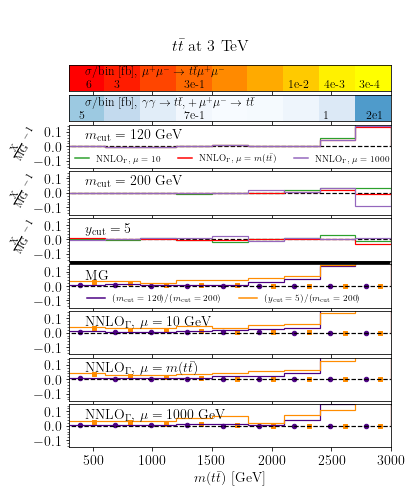

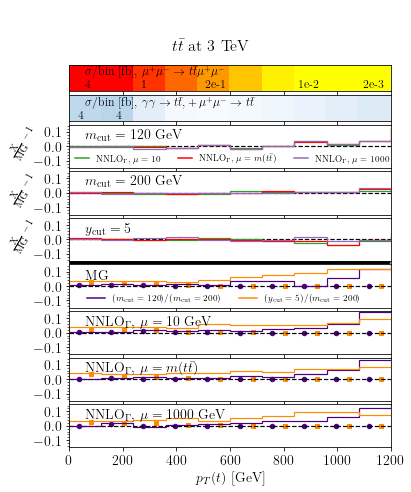

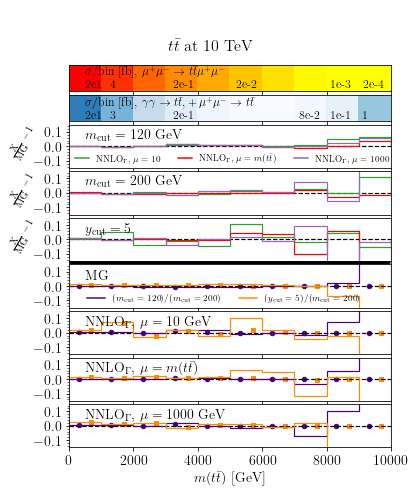

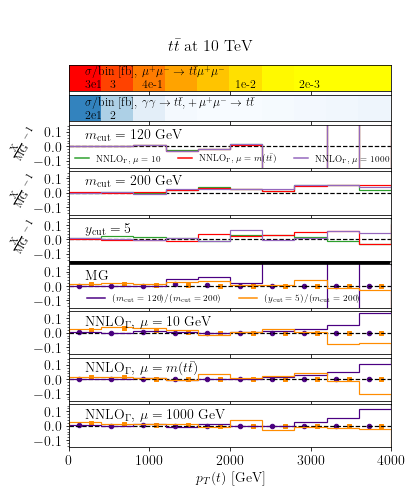

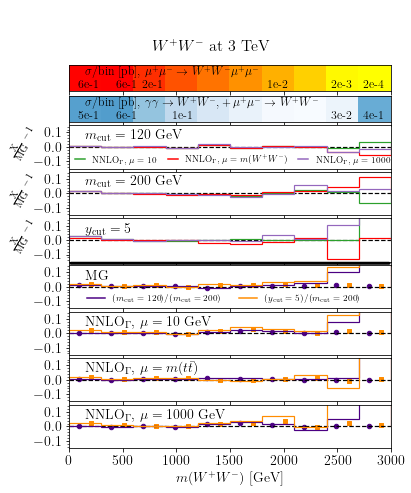

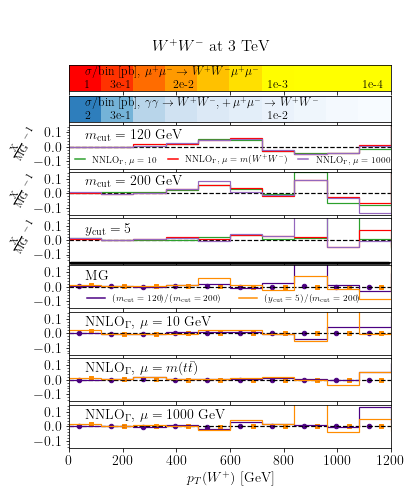

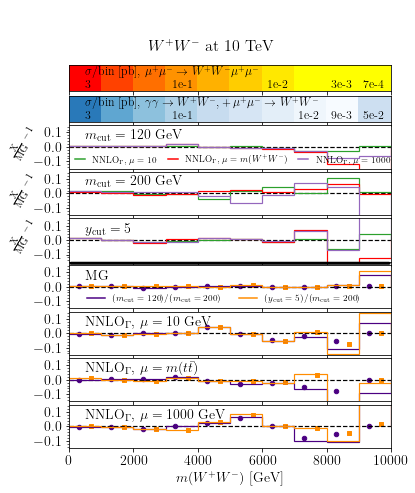

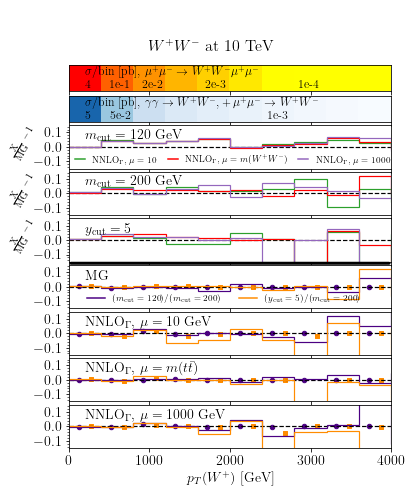

In [66]:
# Main plots for the technical paper
# mtt, compare m[mumu]>200 with ycuts
from matplotlib.colors import LogNorm
nrebin = 5 
import math
import itertools

allcolors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values()) + list(mcolors.XKCD_COLORS.values())
allcolors[1] = 'black'
allcolors[0] = 'blue'
allcolors[3] = 'red'

def get_label_pos(histo, xdel = 0., ypos=0.5):
    """find the label positions where the log10 of the xsection per bin increases by one unity
    always move towards the maximum"""
    imax = histo['y'].index(max(histo['y']))
    # from the left to the right
    lastlog = -20
    labels_left = []
    labels_left.append((histo['x'][imax], ypos, histo['y'][imax]))
    # from the left to the max
    for x, y in zip(histo['x'][:imax], histo['y'][:imax]):
        if y == 0: continue
        if lint(math.log10(y)) != lastlog:
            lastlog = lint(math.log10(y))
            #labels_left.append((x, ypos, 10.**lastlog))
            labels_left.append((x+xdel, ypos, y))
    labels_right = []
    # from the right to the max
    lastlog=-20
    for x, y in reversed(list(zip(histo['x'][imax+1:], histo['y'][imax+1:]))):
        if y == 0: continue
        if lint(math.log10(y)) != lastlog:
            lastlog = lint(math.log10(y))

            #labels_right.append((x, ypos,10.**lastlog))
            labels_right.append((x+xdel, ypos,y))
    return labels_left + list(reversed(labels_right))

def lint(v):
    """returns the largest integer i for which i < v """
    if v > 0:
        return int(v)
    else:
        return int(v) - 1

def put_labels(ax, labels, color='w', fontsize=11, rotation=0):
    for x, y, v in labels:
        #if int(v) != 0:
        #    ss = '%d' % v
        #elif int(v*10) !=0:
        #    ss = '%.1f' % v
        #    ss = ss[1:]
        #elif int(v*100) !=0:
        #    ss = '%.2f' % v
        #    ss = ss[1:]
        #elif int(v*1000) !=0:
        #    ss = '%.3f' % v
        #    ss = ss[1:]
        #elif int(v*10000) !=0:
        #    ss = '%.4f' % v
        #    ss = ss[1:]
        #else:
        #    ss = 'AAAA'
        ss = "%.0e" % v
        ss = ss.replace('e+00', '')
        ss = ss.replace('+0', '')
        ss = ss.replace('-0', '-')
        ax.annotate(ss, xy = (x*0.98,y), color = color, fontsize= fontsize, rotation=rotation)
    
            
allcolors[6] = 'darkorange'
allcolors[5] = 'indigo'        
    
for p, en, o in itertools.product(['tt', 'ww'], [3,10], ['mtt', 'pttop']):
#for p, en, o in itertools.product(['ww'], [3], ['mtt']):

#for p, en in itertools.product(['tt',], [3,10]):
    print(p, en, o)
    fname_mg_m200 = os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_biasmtt4_new.dat' % (o, en))
    if en==10:
        fname_mg_m200_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_biasmtt2_new.dat' % en)
    fname_nnlo1000_m200 = os.path.join(p, 'run_%dtev_comparemassive_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_m200 = os.path.join(p, 'run_%dtev_comparemassive_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_m200 = os.path.join(p, 'run_%dtev_comparemassive_mumtt' % en, 'MADatNLO.HwU')
    
    fname_mg_y5 = os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_ymax5_biasmtt4_new.dat' % (o, en))
    if en ==10:
        fname_mg_y5_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_ymax5_biasmtt2_new.dat' % en)
              
    fname_nnlo1000_y5 = os.path.join(p, 'run_%dtev_comparemassive_ymax5.0_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_y5 = os.path.join(p, 'run_%dtev_comparemassive_ymax5.0_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_y5 = os.path.join(p, 'run_%dtev_comparemassive_ymax5.0_mumtt' % en, 'MADatNLO.HwU')

    fname_nnlo1000_m120 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_m120 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_m120 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_mumtt' % en, 'MADatNLO.HwU')
    
    if en != 10:
        fname_mg_m120 = os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_mcut120_biasmtt4_new.dat' % (o, en))
    else:
        fname_mg_m120 = os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_mcut120_biasmtt2_new.dat' % (o, en))

    if en ==10:
        fname_mg_m120_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_mcut120_biasmtt2_new.dat' % en)     
    
    if en == 10 and o == 'pttop':
        fname_mg_y5 = [os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_ymax5_biasptt2_new_PTBIN%d.dat' % (o, en, ib+1)) 
                       for ib in range(5)] 
        fname_mg_m200 = [os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_biasptt2_new_PTBIN%d.dat' % (o, en, ib+1)) 
                       for ib in range(5)] 
        fname_mg_m120 = [os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_mcut120_biasptt2_new_PTBIN%d.dat' % (o, en, ib+1)) 
                       for ib in range(5)] 
        #fname_mg_m120 = [os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_mcut120_nobias_new_PTBIN%d.dat' % (o, en, ib+1)) 
        #               for ib in range(4)] + [os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_mcut120_nobias_new_PTBIN45.dat' % (o, en))] 
                       
    fname_lotot = os.path.join(p, 'run_%dtev_NLO_mumtt_msb_03permil' % en, 'MADatNLO.HwU')
    
    if o == 'mtt':
        obsrange = (0,en*1000)
        nrebin = 5
    if o == 'pttop':
        obsrange = (0,en*1000/2)
        nrebin = 2
        
    #histograms
    
    if en == 10 and o == 'pttop':
        hlist = [get_histo_from_datfile(f, 5e5, nrebin) for f in fname_mg_y5]
        h_mg_y5 = hlist[0]
        for h in hlist[1:]:
            h_mg_y5 += h
        hlist = [get_histo_from_datfile(f, 5e5, nrebin) for f in fname_mg_m200]
        h_mg_m200 = hlist[0]
        for h in hlist[1:]:
            h_mg_m200 += h
        hlist = [get_histo_from_datfile(f, 5e5, nrebin) for f in fname_mg_m120]
        h_mg_m120 = hlist[0]
        for h in hlist[1:]:
            h_mg_m120 += h        
    else:
        h_mg_y5 = get_histo_from_datfile(fname_mg_y5, 1e6, nrebin)
        h_mg_m120 = get_histo_from_datfile(fname_mg_m120, 1e6, nrebin)
        h_mg_m200 = get_histo_from_datfile(fname_mg_m200, 1e6, nrebin)
    
    if en == 10 and o == 'mtt':
        h_mg_m120_other = get_histo_from_datfile(fname_mg_m120_other, 1e6, nrebin)
        h_mg_m200_other = get_histo_from_datfile(fname_mg_m200_other, 1e6, nrebin)
        h_mg_y5_other = get_histo_from_datfile(fname_mg_y5_other, 1e6, nrebin)
        h_mg_m120.replacefirstbins(h_mg_m120_other, 2001.)
        h_mg_m200.replacefirstbins(h_mg_m200_other, 2001.)
        h_mg_y5.replacefirstbins(h_mg_y5_other, 2001.)
    
    h_nnlo_1000_m200 = get_histo_from_file(fname_nnlo1000_m200, o, 'TOT', nrebin)
    h_nnlo_1000_y5 = get_histo_from_file(fname_nnlo1000_y5, o, 'TOT', nrebin)
    h_nnlo_1000_m120 = get_histo_from_file(fname_nnlo1000_m120, o, 'TOT', nrebin)
    
    h_nnlo_mtt_m200 = get_histo_from_file(fname_nnlomtt_m200, o, 'TOT', nrebin)
    h_nnlo_mtt_y5 = get_histo_from_file(fname_nnlomtt_y5, o, 'TOT', nrebin)
    h_nnlo_mtt_m120 = get_histo_from_file(fname_nnlomtt_m120, o, 'TOT', nrebin)

    h_nnlo_10_m200 = get_histo_from_file(fname_nnlo10_m200, o, 'TOT', nrebin)
    h_nnlo_10_y5 = get_histo_from_file(fname_nnlo10_y5, o, 'TOT', nrebin)
    h_nnlo_10_m120 = get_histo_from_file(fname_nnlo10_m120, o, 'TOT', nrebin)
        
    h_lotot = get_histo_from_file(fname_lotot, o, 'LO', nrebin)
    h_loaa = get_histo_from_file(fname_lotot, o, 'LOAA', nrebin)
    h_ratio_loaa = h_loaa/h_lotot

    # now the figure
    fig, axes = plt.subplots(nrows = 9, ncols= 1, sharex = True, 
                                         gridspec_kw={'height_ratios': [1.2,1.2,2,2,2,2,2,2,2]})
    fig.set_size_inches(7*0.75,7)
    fig.suptitle("\n\n" + "    $" + final_state[p] + '$ at %d TeV' % en, fontsize=16, y=1.00) 
        
    for ax in axes:
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0, pos.width*1.1, pos.height*1.1])
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        xrange = obsrange
        if p == 'tt' and en == 3 and o == 'mtt':
            xrange = (300, obsrange[1])
        if o == 'pttop':
            xrange = (0,obsrange[1]/10.*8)
        ax.set_xlim(xrange)


    textlab_pos = xrange[0] + (xrange[1] - xrange[0])/20.        
        
    # first inset, ratio with the m(200) cut wrt MG
    ax = axes[0]
    #ax.set_ylim(0.85,1.15)
    #h_ratio = h_mg_m200/h_mg_m200
    if p == 'tt':
        unit = 1000. # convert to fb
        sunit = 'fb'
    elif p == 'ww':
        unit = 1. #stay in pb
        sunit = 'pb'
    
    heatmap=ax.pcolor([h_mg_m200['x']]*2, [[0]*h_mg_m200['nbins'], [1]*h_mg_m200['nbins']], [[y*unit for y in h_mg_m200['y']]]*2,
             norm=LogNorm(vmin=h_mg_m200.minv(xrange)*unit*10, vmax=h_mg_m200.maxv(xrange)*unit), cmap='autumn_r', shading='nearest')
    #contour=ax.contour([h_mg_m200['xlo']]*2, [[0]*h_mg_m200['nbins'], [1]*h_mg_m200['nbins']], [h_mg_m200['y']]*2,
    #                  levels=[10**i for i in range(-20,20,1)], colors='w')
    # put the labels of xsection levels
    put_labels(ax, get_label_pos(h_mg_m200*unit,h_mg_m200.binsize*-0.2,-0.25), color='black', fontsize=12)
    ax.annotate('$\\sigma/\\textrm{bin}\\,\\, [\\textrm{%s}]$, $\\mu^+\\mu^- \\to %s \\mu^+\\mu^-$' % (sunit, final_state[p]), xy = (textlab_pos,0.75), color = 'black', fontsize= 12)

    ax.get_yaxis().set_visible(False)
    
    ax = axes[1]
    heatmap=ax.pcolor([h_lotot['x']]*2, [[0]*h_lotot['nbins'], [1]*h_lotot['nbins']], [[y*unit for y in h_lotot['y']]]*2,
             norm=LogNorm(vmin=h_lotot.minv(xrange)*unit, vmax=h_lotot.maxv(xrange)*unit*10), cmap='Blues', shading='nearest')
    #contour=ax.contour([h_mg_m200['xlo']]*2, [[0]*h_mg_m200['nbins'], [1]*h_mg_m200['nbins']], [h_mg_m200['y']]*2,
    #                  levels=[10**i for i in range(-20,20,1)], colors='w')
    # put the labels of xsection levels
    put_labels(ax, get_label_pos(h_lotot*unit,h_mg_m200.binsize*-0.2,-0.25), color='black', fontsize=12)#, rotation=65)
    ax.annotate('$\\sigma/\\textrm{bin}\\,\\, [\\textrm{%s}]$, $\\gamma\\gamma\\to %s, +\\,\\mu^+\\mu^- \\to %s$' % (sunit, final_state[p], final_state[p]), xy = (textlab_pos,0.75), color = 'black', fontsize= 12)

    ax.get_yaxis().set_visible(False)

    ax = axes[2]
    ax.set_ylim(-0.15,0.15)
    ax.set_ylabel('$\\frac{\\textrm{X}}{\\textrm{MG}}-1$', fontsize=10, rotation=60)
    ax.text(textlab_pos, 0.05, '$m_{\\rm cut} = 120$ GeV')

    h_ratio = h_nnlo_10_m120/h_mg_m120 - 1 
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[2], range=(0,en*1000), 
            label = '${\\textrm{NNLO}_\Gamma,\\,\\mu=10}$')
                #label = '${\\textrm{TOT},\\,\\mu=10}/{\\textrm{MG}} -1$')

    h_ratio = h_nnlo_mtt_m120/h_mg_m120 - 1 
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[3], range=(0,en*1000), 
            label = '${\\textrm{NNLO}_\Gamma,\\,\\mu=%s}$' % xlabels[p]['mtt'][1:-7])
    h_ratio = h_nnlo_1000_m120/h_mg_m120 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[4], range=(0,en*1000), 
            label = '${\\textrm{NNLO}_\Gamma,\\,\\mu=1000}$')
    if p == 'tt':
        update_legend(ax, ncol=3, pos=(-0.005,0.5), handlelength=1.5)
    elif p == 'ww':
        update_legend(ax, ncol=3, pos=(-0.005,0.5), handlelength=1.1, columnspacing=1.2)
        
    ax = axes[3]
    ax.set_ylabel('$\\frac{\\textrm{X}}{\\textrm{MG}}-1$', fontsize=10, rotation=60)

    ax.set_ylim(-0.15,0.15)
    ax.text(textlab_pos, 0.05, '$m_{\\rm cut} = 200$ GeV')

    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    
    h_ratio = h_nnlo_10_m200/h_mg_m200 - 1 
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[2], range=(0,en*1000),)
    h_ratio = h_nnlo_mtt_m200/h_mg_m200 - 1 
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[3], range=(0,en*1000),)
    h_ratio = h_nnlo_1000_m200/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[4], range=(0,en*1000),)

   
    # third inset, ratio with the y=5 cut wrt MG
    ax = axes[4]
    ax.set_ylabel('$\\frac{\\textrm{X}}{\\textrm{MG}}-1$', fontsize=10, rotation=60)

    ax.set_ylim(-0.15,0.15)
    ax.text(textlab_pos, 0.05, '$y_{\\rm cut}=5$')
    h_ratio = h_mg_y5/h_mg_y5
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))

    h_ratio = h_nnlo_10_y5/h_mg_y5 - 1 
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[2], range=(0,en*1000),)
    h_ratio = h_nnlo_mtt_y5/h_mg_y5 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[3], range=(0,en*1000),)
    h_ratio = h_nnlo_1000_y5/h_mg_y5 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[4], range=(0,en*1000),)
    

    #ratios y=2.5 , y=5 /m200, madgraph
    ax = axes[5]
    # put a thick line above
    ax.annotate('', xy=(0.0, 1.04), xycoords='axes fraction', xytext=(1., 1.04), arrowprops=dict(arrowstyle="-", color='black', 
                                                                                             linewidth='3'))
    ax.set_ylim(-0.15,0.15)
    ax.text(textlab_pos, 0.05, 'MG')
    h_ratio = h_mg_m200/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_mg_m120/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = '$({m_{\\rm cut}=120})/({m_{\\rm cut}=200})$')
    h_ratio = h_mg_y5/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = '$({y_{\\rm cut}=5})/({m_{\\rm cut}=200})$')

    h_ratio_aa = h_ratio_loaa * (h_mg_m120/h_mg_m200 - 1)
    binsize = en*1000/h_ratio_aa['nbins']
    ax.scatter([x - binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 'o', color = allcolors[5], s = 20)

    h_ratio_aa = h_ratio_loaa * (h_mg_y5/h_mg_m200 - 1)
    ax.scatter([x + binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 's', color = allcolors[6], s = 20)
    
    update_legend(ax, ncol=2, pos=(0.03,0.5))
    
    
    #ratios y=2.5 , y=5 /m200, NNLO mu10
    ax = axes[6]
    ax.set_ylim(-0.15,0.15)
    ax.text(textlab_pos, 0.05, 'NNLO$_{\Gamma}$, $\\mu=10$ GeV')
    h_ratio = h_nnlo_10_m200/h_nnlo_10_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_nnlo_10_m120/h_nnlo_10_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = 'm120/m200')
    h_ratio = h_nnlo_10_y5/h_nnlo_10_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = 'y5/m200')
    
    h_ratio_aa = h_ratio_loaa * (h_nnlo_10_m120/h_nnlo_10_m200 - 1)
    binsize = en*1000/h_ratio_aa['nbins']
    ax.scatter([x - binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 'o', color = allcolors[5], s = 20)

    h_ratio_aa = h_ratio_loaa * (h_nnlo_10_y5/h_nnlo_10_m200 - 1)
    ax.scatter([x + binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 's', color = allcolors[6], s = 20)
    
    #ratios y=2.5 , y=5 /m200, NNLO mumtt
    ax = axes[7]
    ax.set_ylim(-0.15,0.15)
    ax.text(textlab_pos, 0.05, 'NNLO$_{\Gamma}$, $\\mu =m(t\\bar t)$')
    h_ratio = h_nnlo_mtt_m200/h_nnlo_mtt_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_nnlo_mtt_m120/h_nnlo_mtt_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = 'm120/m200')
    h_ratio = h_nnlo_mtt_y5/h_nnlo_mtt_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = 'y5/m200')

    h_ratio_aa = h_ratio_loaa * (h_nnlo_mtt_m120/h_nnlo_mtt_m200 - 1)
    binsize = en*1000/h_ratio_aa['nbins']
    ax.scatter([x - binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 'o', color = allcolors[5], s = 20)

    h_ratio_aa = h_ratio_loaa * (h_nnlo_mtt_y5/h_nnlo_mtt_m200 - 1)
    ax.scatter([x + binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 's', color = allcolors[6], s = 20)
    
    
    #ratios y=2.5 , y=5 /m200, NNLO mu1000
    ax = axes[8]
    ax.set_ylim(-0.15,0.15)
    ax.text(textlab_pos, 0.05, 'NNLO$_{\Gamma}$, $\\mu=1000$ GeV')
    h_ratio = h_nnlo_1000_m200/h_nnlo_1000_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_nnlo_1000_m120/h_nnlo_1000_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = 'm120/m200')
    h_ratio = h_nnlo_1000_y5/h_nnlo_1000_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = 'y5/m200')

    h_ratio_aa = h_ratio_loaa * (h_nnlo_1000_m120/h_nnlo_1000_m200 - 1)
    binsize = en*1000/h_ratio_aa['nbins']
    ax.scatter([x - binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 'o', color = allcolors[5], s = 20)

    h_ratio_aa = h_ratio_loaa * (h_nnlo_1000_y5/h_nnlo_1000_m200 - 1)
    ax.scatter([x + binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 's', color = allcolors[6], s = 20)
    
    
    ax.set_xlabel('%s' % xlabels[p][o])
    plt.savefig('check_massive2_%s_%s_%dtev.pdf'  % (p,o,en), bbox_inches = 'tight')


tt 3 mtt True
tt 3 mtt False
tt 3 pttop True
tt 3 pttop False
tt 10 mtt True
tt 10 mtt False
tt 10 pttop True
tt 10 pttop False
ww 3 mtt True
ww 3 mtt False
ww 3 pttop True
ww 3 pttop False
ww 10 mtt True
ww 10 mtt False
ww 10 pttop True
ww 10 pttop False


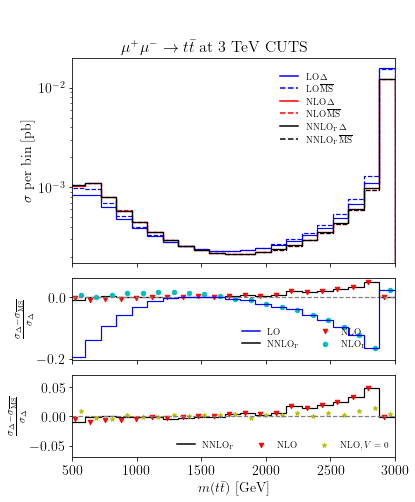

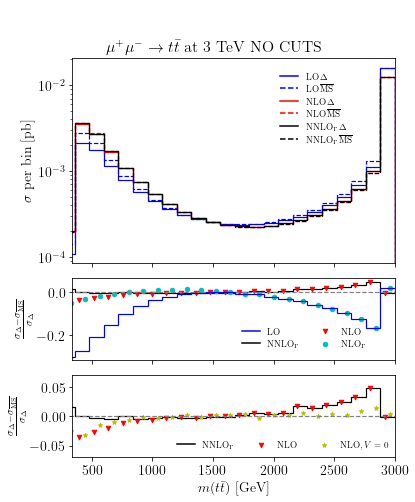

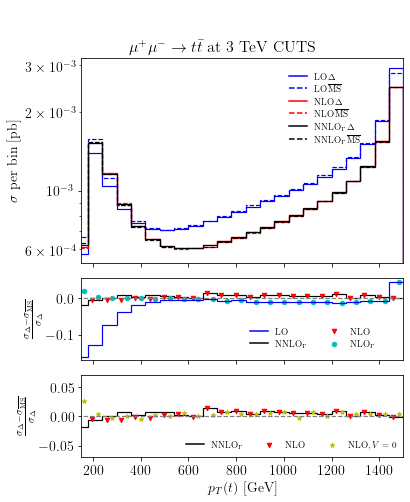

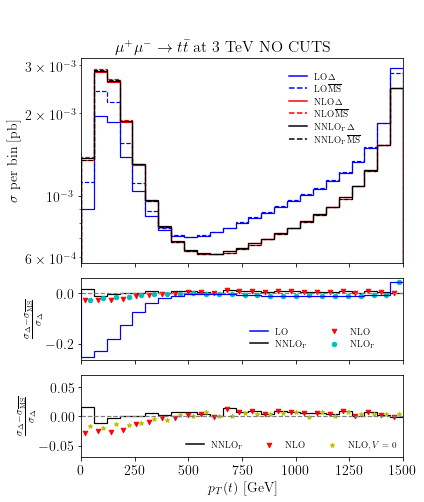

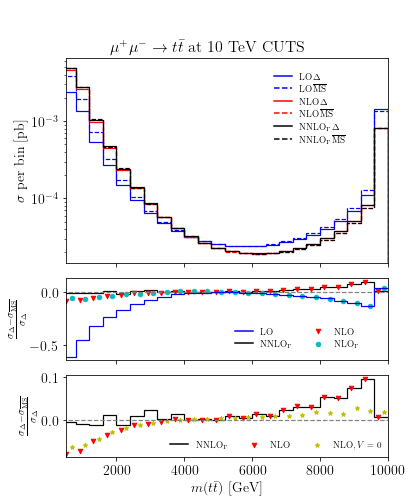

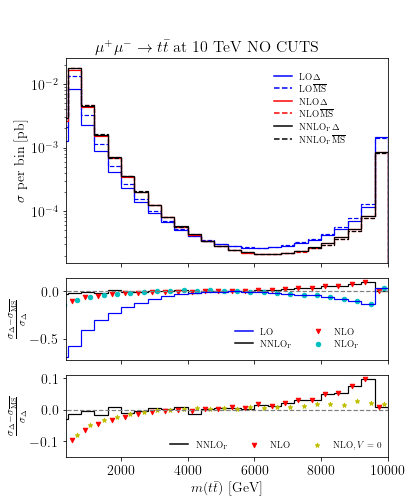

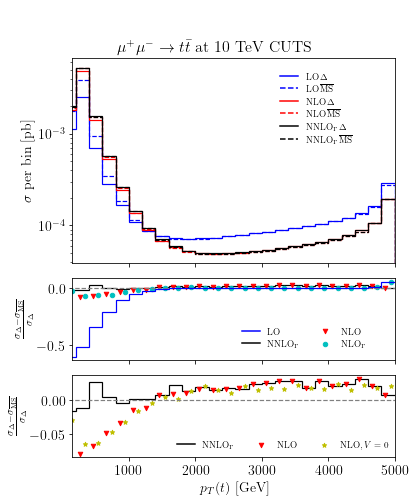

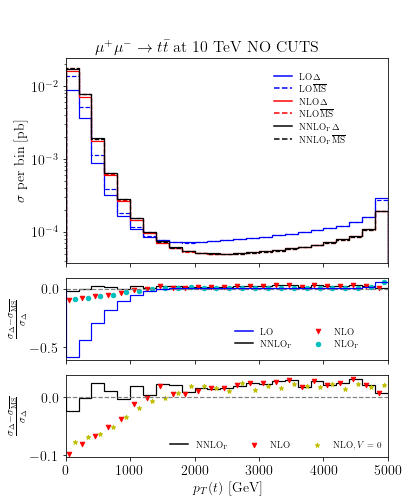

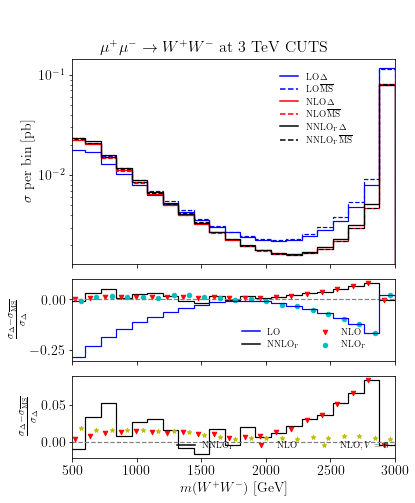

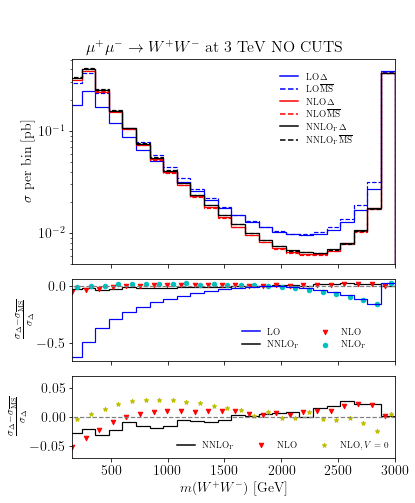

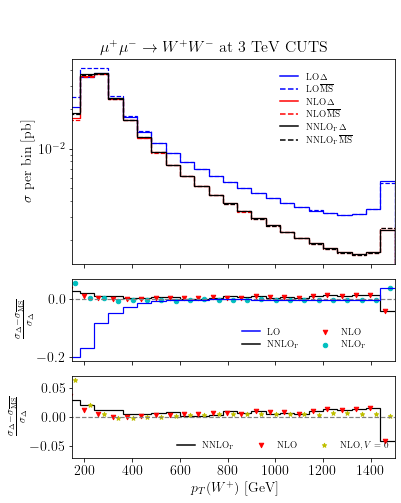

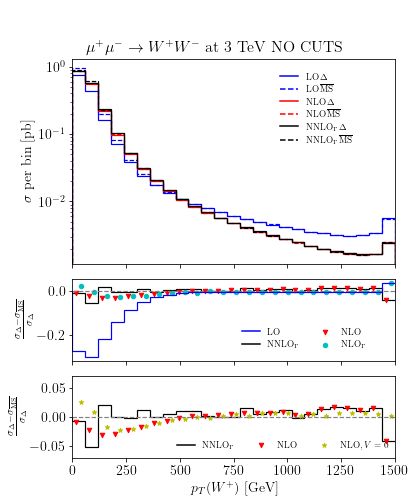

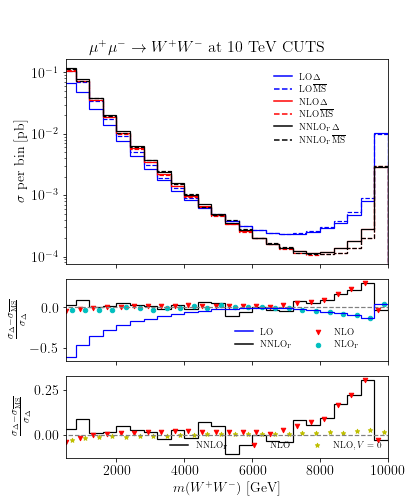

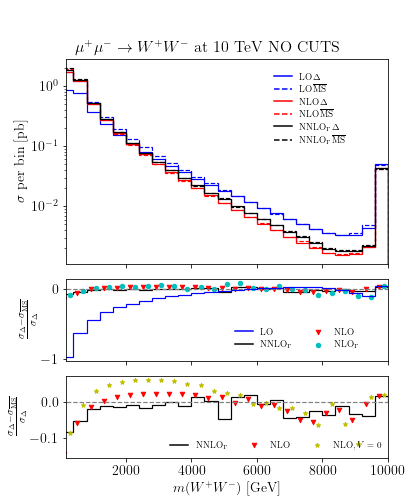

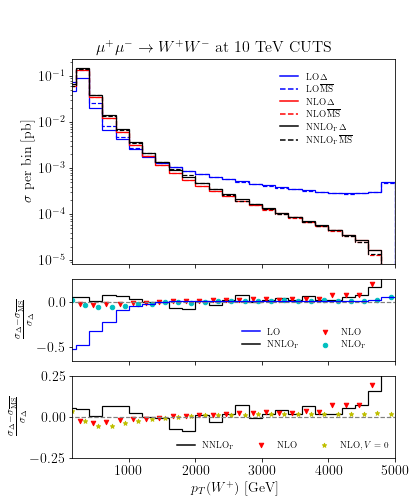

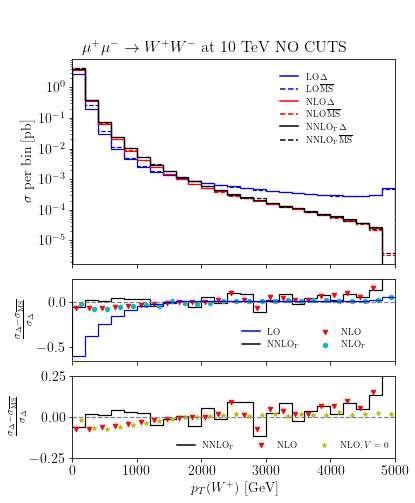

In [61]:
## msbar vs delta
import itertools


energies = [1,3,10]
energies = [3,10]

#observables = ['mtt', 'pttt', 'pttop', 'top rap', 'tt rap']
#observables = ['mtt', 'pttt', 'pttop']
observables = ['mtt', 'pttop', 'top rap', 'tt rap']
observables = ['mtt', 'pttop']



#observables = ['top rap', 'tt rap']

processes = ['tt', 'ww']

proc_string = {'tt': '$\\mu^+\\mu^- \\to t \\bar t$',
               'ww': '$\\mu^+\\mu^- \\to W^+ W^-$'}

allcolors[3] = 'black'
allcolors[1] = 'blue'
allcolors[2] = 'red'
allcolors[4] = 'lightcoral'

nrebin = 2

ylim_dict = {}

for p in processes:
    for en in energies:
        #fname_mg = os.path.join(p, 'run_%dtev_NLO_mumtt_03permil_cuts' % en, 'MADatNLO.HwU')
        #fname_mg_novi = os.path.join(p, 'run_%dtev_NLO_mumtt_03permil_novirt_cuts' % en, 'MADatNLO.HwU')
        fname_nnlo = os.path.join(p, 'run_nnlo%d_fixqp_mufmtt_cuts' % en, 'MADatNLO.HwU')

        fname_mg_msb = os.path.join(p, 'run_%dtev_NLO_mumtt_msb_03permil_cuts' % en, 'MADatNLO.HwU')
        fname_mg_msb_novi = os.path.join(p, 'run_%dtev_NLO_mumtt_msb_03permil_novirt_cuts' % en, 'MADatNLO.HwU')
        if p == 'ww':
            #fname_mg = os.path.join(p, 'run_%dtev_NLO_mumtt_01permil_cuts' % en, 'MADatNLO.HwU')
            #fname_mg_novi = os.path.join(p, 'run_%dtev_NLO_mumtt_01permil_novirt_cuts' % en, 'MADatNLO.HwU')
            fname_mg_msb = os.path.join(p, 'run_%dtev_NLO_mumtt_msb_01permil_cuts' % en, 'MADatNLO.HwU')
            fname_mg_msb_novi = os.path.join(p, 'run_%dtev_NLO_mumtt_msb_01permil_novirt_cuts' % en, 'MADatNLO.HwU')
        fname_nnlo_msb = os.path.join(p, 'run_nnlo%d_fixqp_msb_mufmtt_cuts' % en, 'MADatNLO.HwU')
        if en == 3:
            fname_mg = os.path.join(p, 'run_%dtev_NLO_mumtt_01permil_cuts_symx12' % en, 'MADatNLO.HwU')
            fname_mg_novi = os.path.join(p, 'run_%dtev_NLO_mumtt_01permil_novirt_cuts_symx12' % en, 'MADatNLO.HwU')
        elif en == 10:
            fname_mg = os.path.join(p, 'run_%dtev_NLO_mumtt_005permil_cuts_symx12' % en, 'MADatNLO.HwU')
            fname_mg_novi = os.path.join(p, 'run_%dtev_NLO_mumtt_005permil_novirt_cuts_symx12' % en, 'MADatNLO.HwU')
        #if p == 'ww'  and en == 10:
        #if p == 'ww':
        #    fname_mg_msb_mwwcut = os.path.join(p, 'run_%dtev_NLO_mumtt_msb_mww6000_5permil_cuts' % en, 'MADatNLO.HwU')
        #    fname_mg_msb_novi_mwwcut = os.path.join(p, 'run_%dtev_NLO_mumtt_msb_mww6000_5permil_novirt_cuts' % en, 'MADatNLO.HwU')

        for o, cut in itertools.product(observables, [True,False]):
            print(p, en, o, cut)
            if o == 'mtt':
                nrebin = 2
            else:
                nrebin = 1
            if cut:
                scut = 'C'
            else:
                scut = ''
            #if en == 10 and p =='ww':
            #    if o == 'pttop':
            #        nrebin = 2
            #    else:
            #        nrebin = 5
            #DELTA
            # mg histograms
            fixrate = (o == 'mtt')

            h_lo_mg = get_histo_from_file(fname_mg, o, 'LO%s' % scut, nrebin)#, fixrate, rate_mg_lo)
            h_loaa_mg = get_histo_from_file(fname_mg, o, 'LOAA%s' % scut, nrebin)
            h_nlo_mg = get_histo_from_file(fname_mg, o, 'NLO%s' % scut, nrebin)
            h_nlor_mg = get_histo_from_file(fname_mg, o, 'NLOR%s' % scut, nrebin)
            h_tot_mg = get_histo_from_file(fname_mg, o, 'TOT%s' % scut, nrebin)#, fixrate, rate_mg_tot)
            h_tot_mg_novi = get_histo_from_file(fname_mg_novi, o, 'TOT%s' % scut, nrebin)#, fixrate, rate_mg_tot)
            # nnlo histograms
            h_lo_nnlo = get_histo_from_file(fname_nnlo, o, 'LO%s' % scut, nrebin)
            h_nlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NLO%s' % scut, nrebin)
            h_nnlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NNLO%s' % scut, nrebin)

            #MSBAR
            # mg histograms
            h_lo_mg_msb = get_histo_from_file(fname_mg_msb, o, 'LO%s' % scut, nrebin)#, fixrate, rate_mg_msb_lo)
            h_loaa_mg_msb = get_histo_from_file(fname_mg_msb, o, 'LOAA%s' % scut, nrebin)
            h_nlo_mg_msb = get_histo_from_file(fname_mg_msb, o, 'NLO%s' % scut, nrebin)
            h_nlor_mg_msb = get_histo_from_file(fname_mg_msb, o, 'NLOR%s' % scut, nrebin)
            h_tot_mg_msb = get_histo_from_file(fname_mg_msb, o, 'TOT%s' % scut, nrebin)#, fixrate, rate_mg_msb_tot)
            h_tot_mg_msb_novi = get_histo_from_file(fname_mg_msb_novi, o, 'TOT%s' % scut, nrebin)#, fixrate, rate_mg_msb_tot)
            # nnlo histograms
            h_lo_nnlo_msb = get_histo_from_file(fname_nnlo_msb, o, 'LO%s' % scut, nrebin)
            h_nlo_nnlo_msb = get_histo_from_file(fname_nnlo_msb, o, 'NLO%s' % scut, nrebin)
            h_nnlo_nnlo_msb = get_histo_from_file(fname_nnlo_msb, o, 'NNLO%s' % scut, nrebin)
            
            #if p == 'ww' and o == 'mtt' and en == 10:
            #    h_lo_mg_msb_mwwcut = get_histo_from_file(fname_mg_msb_mwwcut, o, 'LO%s' % scut, nrebin)
            #    h_tot_mg_msb_mwwcut = get_histo_from_file(fname_mg_msb_mwwcut, o, 'TOT%s' % scut, nrebin)
            #    h_tot_mg_msb_novi_mwwcut = get_histo_from_file(fname_mg_msb_novi_mwwcut, o, 'TOT%s' % scut, nrebin)
            #    h_lo_mg_msb.replacelastbins(h_lo_mg_msb_mwwcut, 5999)
            #    h_tot_mg_msb.replacelastbins(h_tot_mg_msb_mwwcut, 5999)
            #    h_tot_mg_msb_novi.replacelastbins(h_tot_mg_msb_novi_mwwcut, 5999)



            # now the figure
            fig, axes = plt.subplots(nrows = 3, ncols= 1, sharex = True,
                                     gridspec_kw={'height_ratios': [2.5, 1,1]})
            fig.set_size_inches(7*0.75,7)
            #fig.suptitle("\n\n" + "    " + proc_string[p] + '$\\mu^+\\mu^-$' + ' at %d TeV' % en, fontsize=16, y=1.00) 
            if cut:
                sscut = 'CUTS'
            else:
                sscut = 'NO CUTS'
            fig.suptitle("\n\n" + "    " + proc_string[p] + ' at %d TeV   %s' % (en, sscut), fontsize=16, y=1.02 ) 

            for ax in axes:
                pos = ax.get_position()
                ax.set_position([pos.x0, pos.y0, pos.width*1.1, pos.height*1.1])
                ax.yaxis.set_minor_locator(AutoMinorLocator())

            #main frame, LO effect show absolute xsec
            for ax in axes[1:]:
                ax.set_ylabel("$\\frac{\\sigma_{\\Delta}-\\sigma_{\\overline{\\rm MS}}}{\sigma_{\\Delta}}$")

            if o == 'mtt':
                obsrange = (0.,en*1000.)
            elif o == 'pttt':
                obsrange = (0.,en*1000.)
            elif o in ['thetatt']:
                obsrange = (0.,math.pi)
            elif o in ['top rap', 'tt rap']:
                obsrange = (-12,12)
                
            if o == 'mtt' and p == 'tt':
                if cut:
                    ax.set_xlim(500,en*1000)
                else:
                    ax.set_xlim(340,en*1000)
            if o == 'mtt' and p == 'ww':
                ax.set_xlim(160,en*1000)
                if cut:
                    ax.set_xlim(500,en*1000)
                    
            if o in ['pttt', 'pttop']:
                ax.set_xlim(0,en*1000/2)
                if cut and o == 'pttop':
                    ax.set_xlim(150,en*1000/2)
            if o in ['thetatt']:
                ax.set_xlim(0,math.pi)
            if o in ['top rap', 'tt rap']:
                if cut:
                    ax.set_xlim(-2.6,2.6)
                else:
                    ax.set_xlim(-4.6,4.6)
                    if en == 3 and o == 'tt rap':
                        ax.set_xlim(-3.1,3.1)                    
                
            binwidth = (obsrange[1]-obsrange[0])/h_tot_mg['nbins']
                
            # absolute xsect
            ax = axes[0]
            ax.set_ylabel("$\sigma$ per bin [pb]")
            ax.set_yscale('log')
            hplot = h_lo_mg
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}\\,\\Delta$',
                   linewidth=lw, color=allcolors[1], linestyle='solid', range=obsrange)
            hplot = h_lo_mg_msb
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}\\,\\overline{\\textrm{MS}}$',
                   linewidth=lw, color=allcolors[1], linestyle='dashed', range=obsrange)

            hplot = h_tot_mg
            #ax.scatter([x - hplot.binsize/5.for x in hplot['x']], hplot['y'], marker = 'd', color = allcolors[2], s = 15,
            #                             label = '$\\textrm{NLO}\\,\\Delta$')
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{NLO}\\,\\Delta$',
                   linewidth=lw, color=allcolors[2], linestyle='solid', range=obsrange)
            
            hplot = h_tot_mg_msb
            #ax.scatter([x + hplot.binsize/5.for x in hplot['x']], hplot['y'], marker = 'X', color = allcolors[2], s = 15,
            #                             label = '$\\textrm{NLO}\\,\\overline{\\textrm{MS}}$')
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{NLO}\\,\\overline{\\textrm{MS}}$',
                   linewidth=lw, color=allcolors[2], linestyle='dashed', range=obsrange)

            hplot = h_tot_mg + h_nnlo_nnlo
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{NNLO}_{\\Gamma}\\,\\Delta$',
                   linewidth=lw, color=allcolors[3], linestyle='solid', range=obsrange)
            hplot = h_tot_mg_msb + h_nnlo_nnlo_msb
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{NNLO}_{\\Gamma}\\,\\overline{\\textrm{MS}}$',
                   linewidth=lw, color=allcolors[3], linestyle='dashed', range=obsrange)

            update_legend(ax,1, pos=(0.62,0.97))

            ax = axes[1]
            ax.set_yscale('linear')

            # total
            #label = '$\\textrm{TOT}=\\textrm{LO}+\\textrm{NLO}+\\textrm{NNLO}^{\\gamma+Z}_\\textrm{\\tiny ISR}$',
            hplot = h_lo_mg
            ax.hist(x = hplot['x'], weights = [0]*hplot['nbins'], histtype= 'step', bins = hplot['nbins'],
                   linewidth=lw, color='gray', linestyle='dashed', range=obsrange)
            
            hplot = (h_lo_mg - h_lo_mg_msb) / h_lo_mg
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}$',
                   linewidth=lw, color=allcolors[1], range=obsrange)
            
            hplot = (h_tot_mg - h_tot_mg_msb) / h_tot_mg
            ax.scatter([x -hplot.binsize/5.for x in hplot['x']], hplot['y'], marker = 'v', color = allcolors[2], s = 20,
                                         label = '$\\textrm{NLO}$')
            
            hplot = (h_lo_mg + h_nlo_nnlo - h_lo_mg_msb - h_nlo_nnlo_msb) / (h_lo_mg + h_nlo_nnlo)
            ax.scatter([x +hplot.binsize/5 for x in hplot['x']], hplot['y'], marker = 'o', color = allcolors[13], s = 20,
                                         label = '$\\textrm{NLO}_{\\Gamma}$')
            
            hplot = (h_tot_mg + h_nnlo_nnlo - h_tot_mg_msb - h_nnlo_nnlo_msb) / (h_tot_mg + h_nnlo_nnlo)
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{NNLO}_{\\Gamma}$',
                   linewidth=lw, color=allcolors[3], range=obsrange, linestyle = 'solid', zorder=-1)
            if p == 'ww' and o == 'pttop' and en==10:
                ax.set_ylim(-0.65,0.25)            

            update_legend(ax, 2, pos=(0.5,0.5))

            ax = axes[2]
            ax.set_yscale('linear')

            hplot = h_lo_mg
            ax.hist(x = hplot['x'], weights = [0]*hplot['nbins'], histtype= 'step', bins = hplot['nbins'],
                   linewidth=lw, color='gray', linestyle='dashed', range=obsrange)

            hplot = (h_tot_mg - h_tot_mg_msb) / h_tot_mg
            ax.scatter([x - hplot.binsize/5.for x in hplot['x']], hplot['y'], marker = 'v', color = allcolors[2], s = 20,
                                         label = '$\\textrm{NLO}$')
            
            hplot = (h_tot_mg_novi - h_tot_mg_msb_novi) / h_tot_mg_novi
            ax.scatter([x + hplot.binsize/5.for x in hplot['x']], hplot['y'], marker = '*', color = allcolors[15], s = 20,
                                         label = '$\\textrm{NLO}, V=0$')

            hplot = (h_tot_mg + h_nnlo_nnlo - h_tot_mg_msb - h_nnlo_nnlo_msb) / (h_tot_mg + h_nnlo_nnlo)
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{NNLO}_{\\Gamma}$',
                   linewidth=lw, color=allcolors[3], range=obsrange, linestyle = 'solid', zorder=-1)
            #check that the ylim are not too tight
            ylim = ax.get_ylim()
            if ylim[0]>-0.07 and ylim[1]<0.07:
                ax.set_ylim(-0.07,0.07)
                
            if p == 'ww' and o == 'pttop' and en==10:
                ax.set_ylim(-0.25,0.25)
            update_legend(ax, 3, pos=(0.3,0.3))

            ax.set_xlabel('%s' % xlabels[p][o])
            
            plt.savefig('delvsmsb_%s%s_%s_%dtev.pdf' % (o.replace(' ',''),scut,p,en), bbox_inches = 'tight')






tt 3 mtt False
tt 3 pttt False
tt 3 pttop False
tt 3 top rap False
tt 3 tt rap False
tt 10 mtt True
tt 10 pttt True
tt 10 pttop True
tt 10 top rap True
tt 10 tt rap True
tt 10 mtt False
tt 10 pttt False
tt 10 pttop False
tt 10 top rap False
tt 10 tt rap False
ww 3 mtt False
ww 3 pttt False
ww 3 pttop False
ww 3 top rap False
ww 3 tt rap False
ww 10 mtt True


<ipython-input-59-ffb657d19047>:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows = 4, ncols= 1, sharex = True,


ww 10 pttt True
ww 10 pttop True
ww 10 top rap True
ww 10 tt rap True
ww 10 mtt False
ww 10 pttt False
ww 10 pttop False
ww 10 top rap False
ww 10 tt rap False


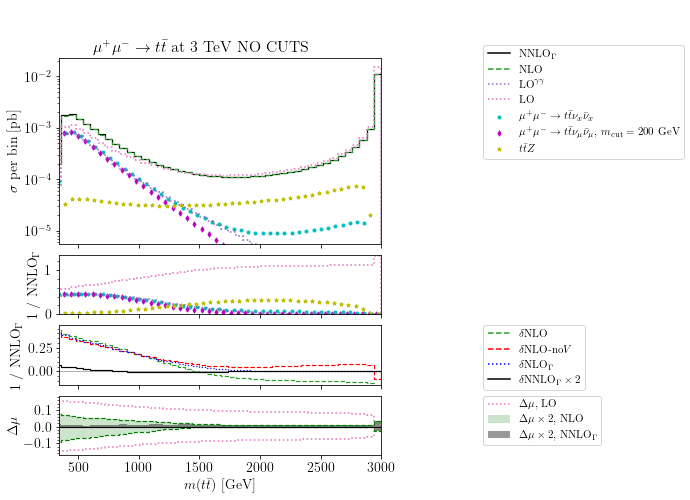

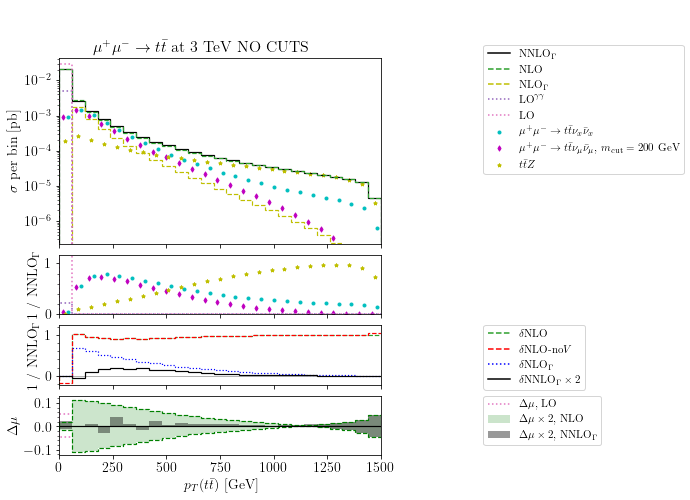

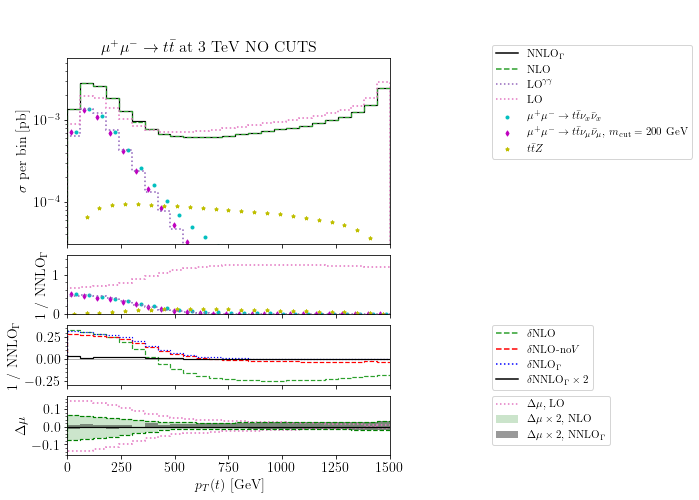

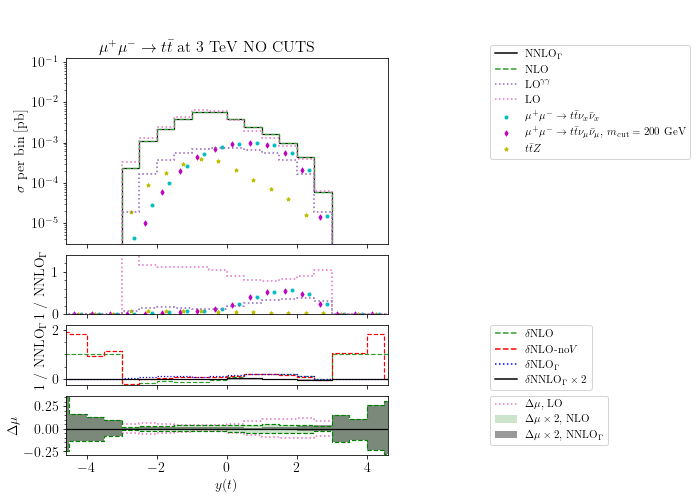

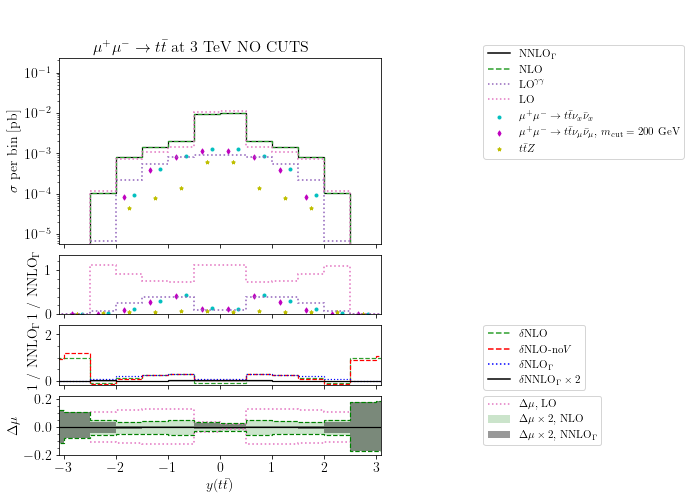

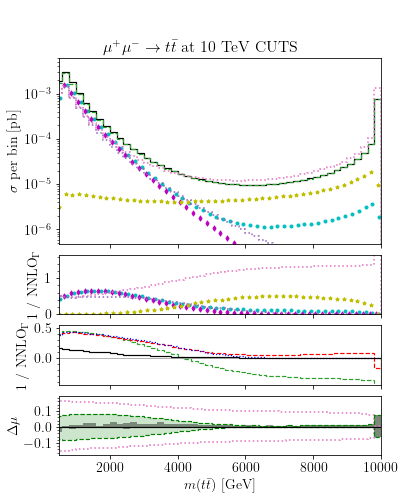

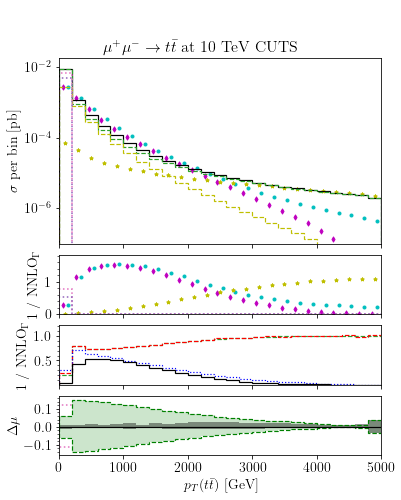

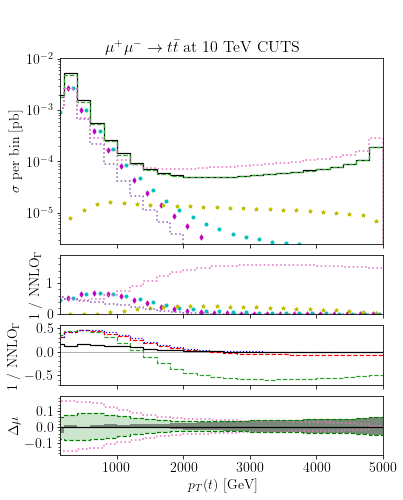

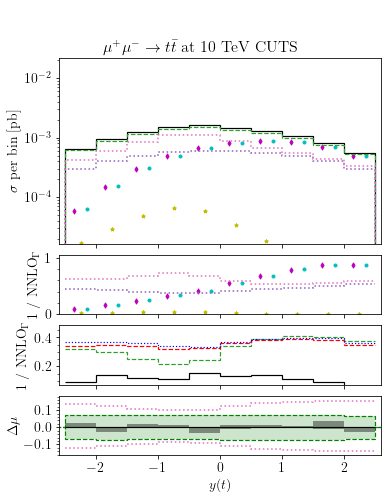

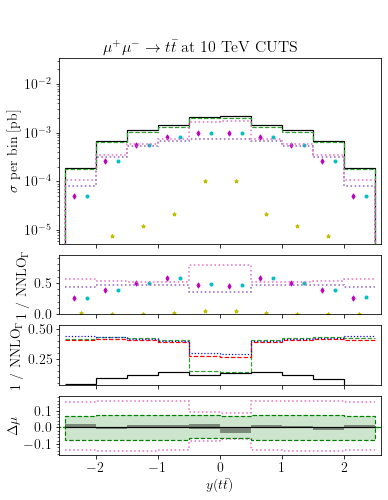

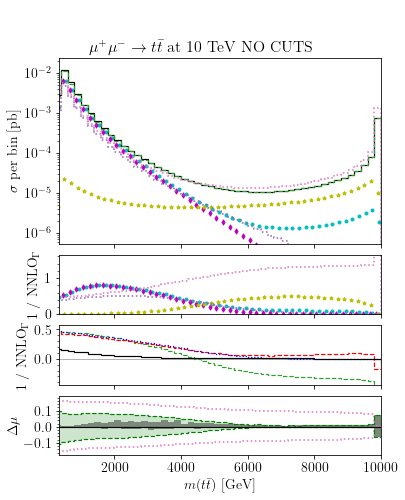

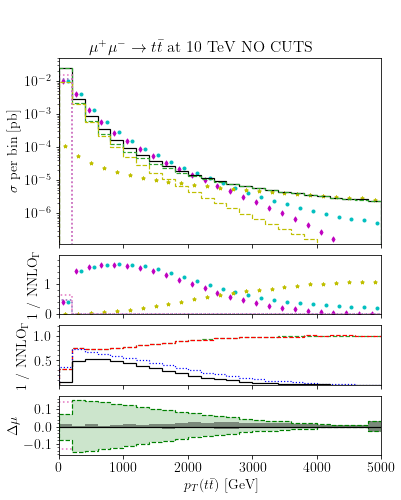

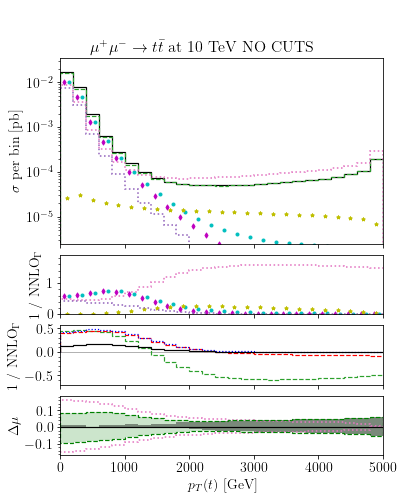

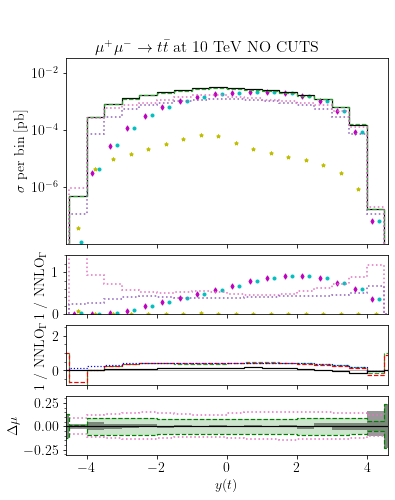

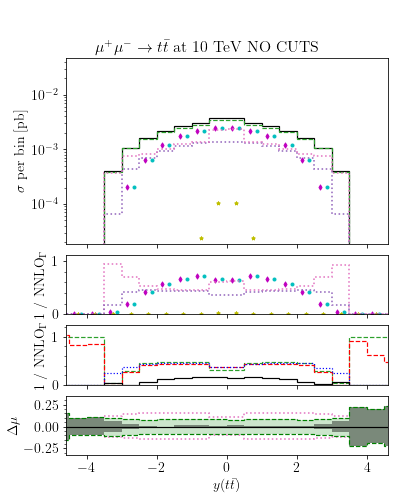

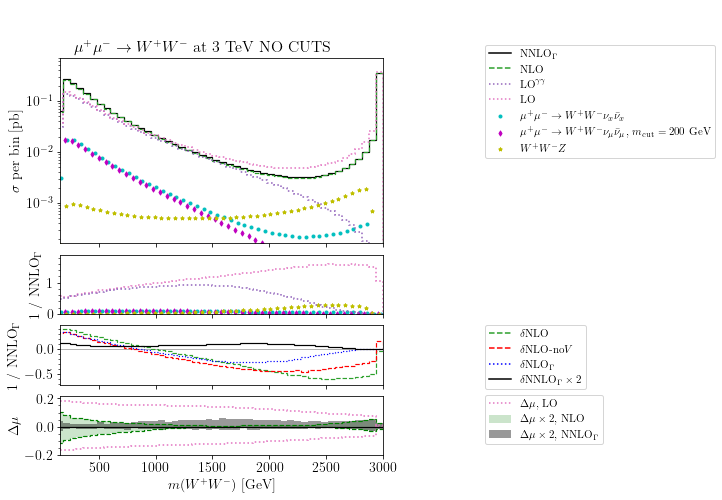

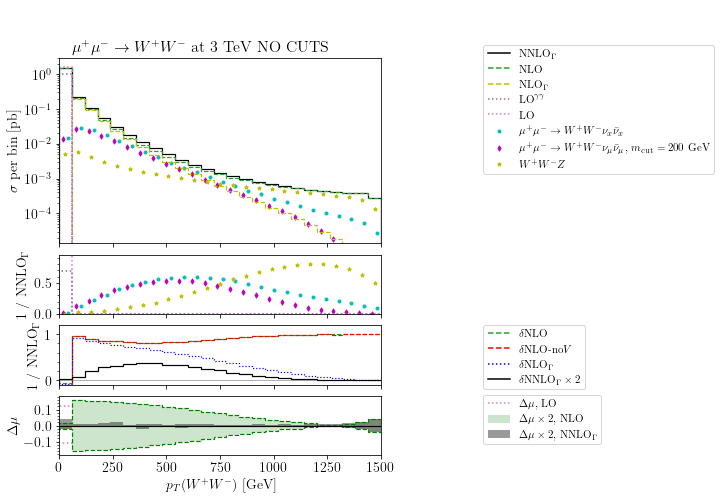

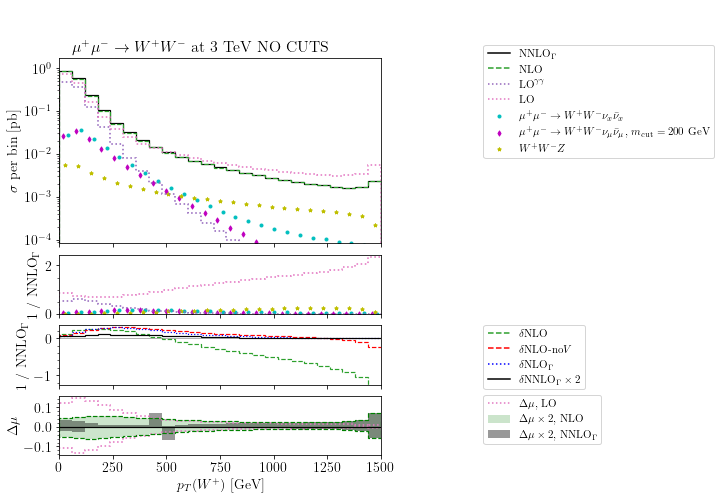

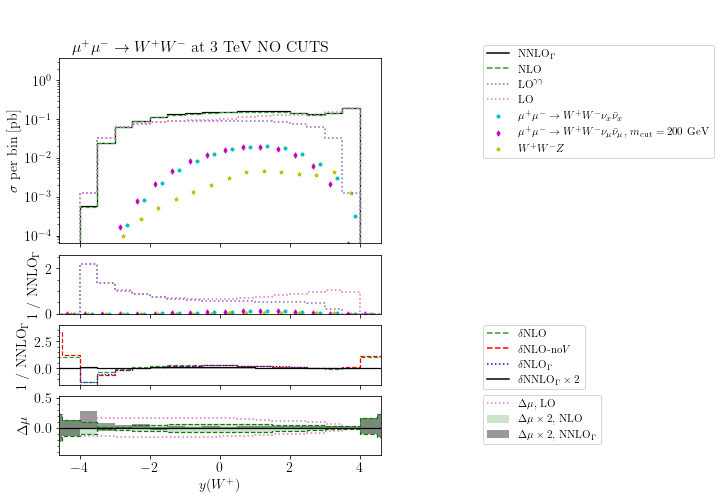

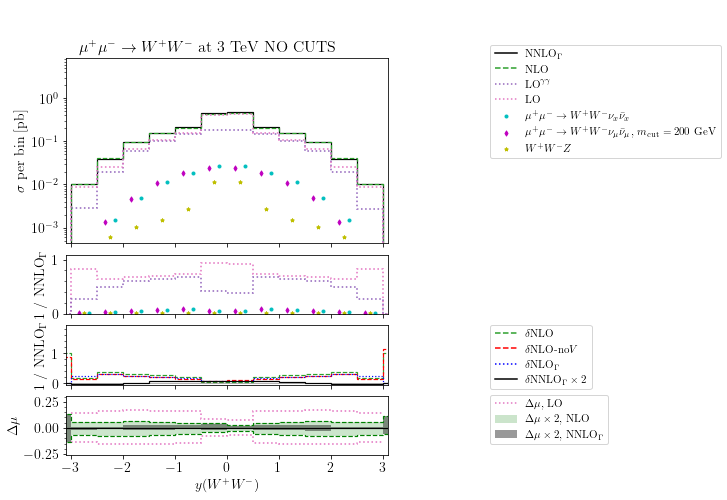

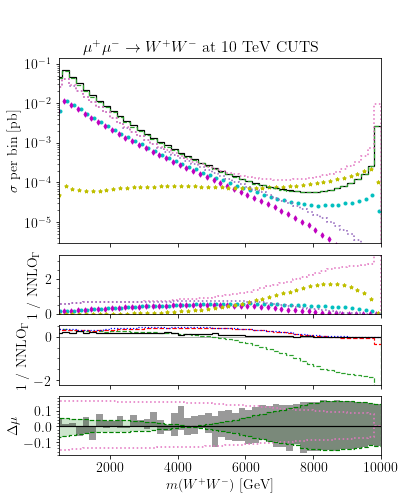

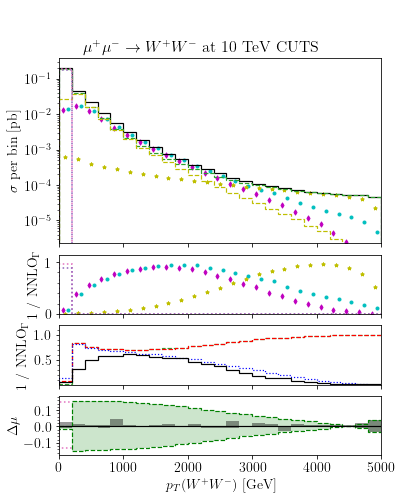

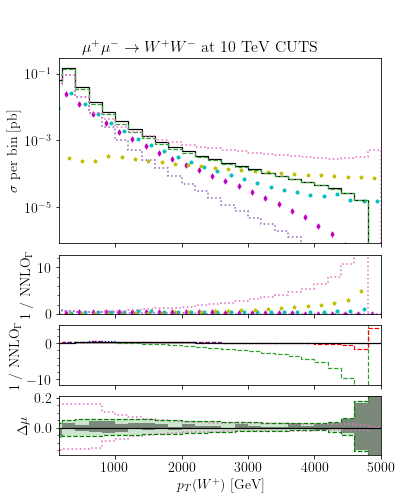

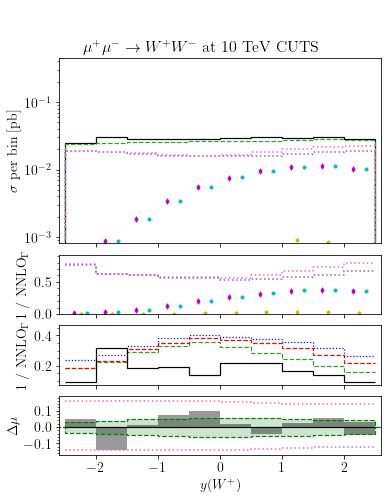

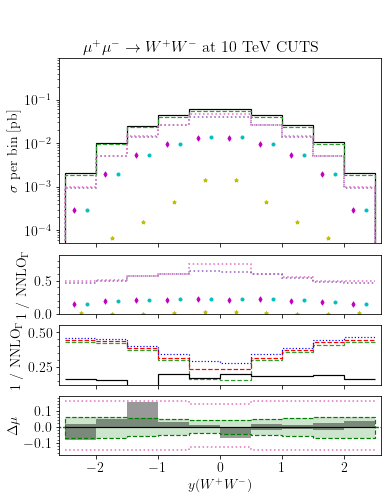

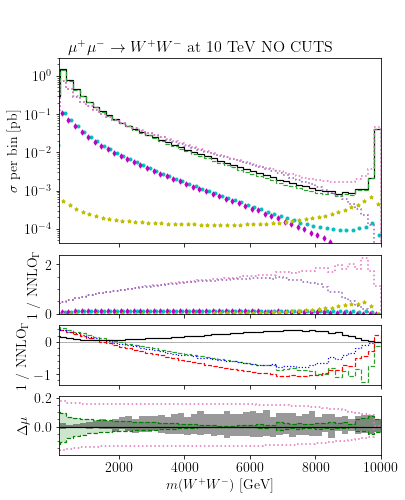

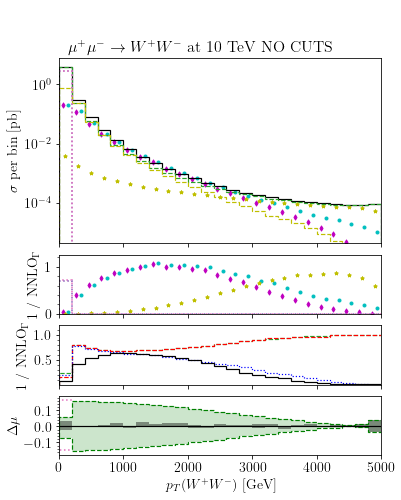

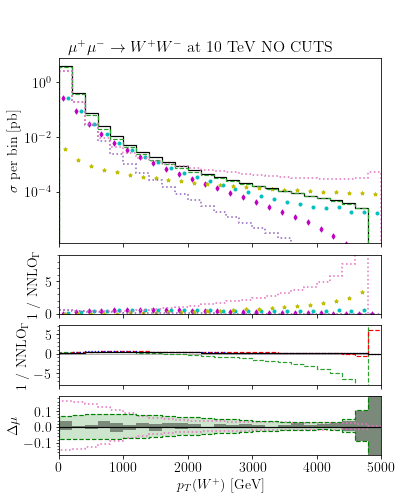

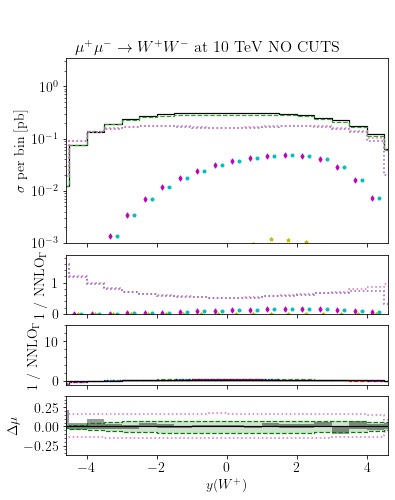

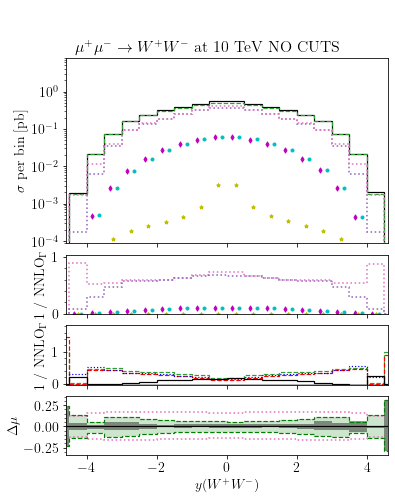

In [59]:
# observables and histograms


energies = [1,3,10]
energies = [3,10]

observables = ['mtt', 'pttt', 'pttop', 'top rap', 'tt rap']
#observables = ['mtt', ]
#observables = ['mtt', 'pttt', 'pttop']
#observables = ['top rap', 'tt rap']

#observables = ['mtt', ]
#observables = ['top rap', 'tt rap']

processes = ['tt', 'ww']
#processes = ['ww',]
#energies = [3]
allcolors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values()) + list(mcolors.XKCD_COLORS.values())
allcolors[1] = 'black'
allcolors[0] = 'blue'
allcolors[3] = 'red'

proc_string = {'tt': '$\\mu^+\\mu^- \\to t \\bar t$',
               'ww': '$\\mu^+\\mu^- \\to W^+ W^-$'}

lwdot = lw*1.3

for p in processes:
    for en, cut in [(3,False), (10,True), (10,False)]:
        if en == 3:
            fname_mg = os.path.join(p, 'run_%dtev_NLO_mumtt_01permil_cuts_symx12' % en, 'MADatNLO.HwU')
            fname_mgnovi = os.path.join(p, 'run_%dtev_NLO_mumtt_01permil_novirt_cuts_symx12' % en, 'MADatNLO.HwU')
        elif en == 10:
            fname_mg = os.path.join(p, 'run_%dtev_NLO_mumtt_005permil_cuts_symx12' % en, 'MADatNLO.HwU')
            fname_mgnovi = os.path.join(p, 'run_%dtev_NLO_mumtt_005permil_novirt_cuts_symx12' % en, 'MADatNLO.HwU')
        #if en == 10 and p == 'ww':
        #    fname_mg = os.path.join(p, 'run_%dtev_NLO_mumtt_01permil_cuts' % en, 'MADatNLO.HwU')
        #    fname_mgnovi = os.path.join(p, 'run_%dtev_NLO_mumtt_01permil_novirt_cuts' % en, 'MADatNLO.HwU')
        
        fname_nnlo = os.path.join(p, 'run_nnlo%d_fixqp_mufmtt_cuts' % en, 'MADatNLO.HwU')
        fname_nnlo_scdn = os.path.join(p, 'run_nnlo%d_fixqp_mufmtt_mufact0.5_cuts' % en, 'MADatNLO.HwU')
        fname_nnlo_scup = os.path.join(p, 'run_nnlo%d_fixqp_mufmtt_mufact2.0_cuts' % en, 'MADatNLO.HwU')
        fname_wbf = os.path.join(p, 'run_Wfusion_%dtev_cuts' % en, 'MADatNLO.HwU')
        fname_ttz = os.path.join(p, 'run_ttZ_%dtev_cuts' % en, 'MADatNLO.HwU')
        fname_sdk = os.path.join(p, 'run_sdk_%dtev_cuts' % en, 'MADatNLO.HwU')

        for o in observables:
        
            print(p, en, o, cut)
            scut = ''
            if cut:
                scut = 'C'
            try:
                # mg histograms
                h_lo_mg = get_histo_from_file(fname_mg, o, 'LO'+scut)
                h_loaa_mg = get_histo_from_file(fname_mg, o, 'LOAA'+scut)
                h_nlo_mgnovi = get_histo_from_file(fname_mgnovi, o, 'NLO'+scut)
                h_nlo_mg = get_histo_from_file(fname_mg, o, 'NLO'+scut)
                h_nlor_mg = get_histo_from_file(fname_mg, o, 'NLOR'+scut)
                h_tot_mg = get_histo_from_file(fname_mg, o, 'TOT'+scut)
                # nnlo histograms
                h_lo_nnlo = get_histo_from_file(fname_nnlo, o, 'LO'+scut, scvarfiles = [fname_nnlo_scdn, fname_nnlo_scup])
                h_nlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NLO'+scut, scvarfiles = [fname_nnlo_scdn, fname_nnlo_scup])
                h_nnlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NNLO'+scut, scvarfiles = [fname_nnlo_scdn, fname_nnlo_scup])
                
                h_tota = h_nnlo_nnlo + h_tot_mg
            except (FileNotFoundError, HistoNotFound) as e:
                print(e)
                continue
            
            try:
                # wfusion histograms
                h_w_tot = get_histo_from_file(fname_wbf, o, 'LO'+scut)
                h_w_vmcut = get_histo_from_file(fname_wbf, o, 'LOVMX'+scut)
                foundww = True
            except (FileNotFoundError, HistoNotFound):
                print('NOT FOUND', fname_wbf)
                foundww = False
                
            h_z_tot = get_histo_from_file(fname_ttz, o, 'LO'+scut)
            h_sdk = get_histo_from_file(fname_sdk, o, 'SDKW'+scut)

            
            # now the figure
            fig, axes = plt.subplots(nrows = 4, ncols= 1, sharex = True, 
                                     gridspec_kw={'height_ratios': [2.5,0.8,0.8,0.8]})
            fig.set_size_inches(7*0.75,7)

            if cut:
                sscut = 'CUTS'
            else:
                sscut = 'NO CUTS'
            fig.suptitle("\n\n" + "    " + proc_string[p] + ' at %d TeV   %s' % (en, sscut), fontsize=16, y=1.015 ) 
            
            for ax in axes:
                pos = ax.get_position()
                ax.set_position([pos.x0, pos.y0, pos.width*1.1, pos.height*1.1])
                ax.yaxis.set_minor_locator(AutoMinorLocator())
            
            ttz_labels = {'tt': '$t\\bar t Z$', 'ww': '$W^+W^- Z$'}

            #main frame, show absolute xsec
            ax = axes[0]
            ax.set_ylabel("$\sigma$ per bin [pb]")
            ax.set_yscale('log')
            if o == 'mtt':
                obsrange = (0.,en*1000.)
            elif o in ['pttt', 'pttop']:
                obsrange = (0.,en*1000.)
            elif o in ['thetatt']:
                obsrange = (0.,math.pi)
            elif o in ['top rap', 'tt rap']:
                obsrange = (-12,12)
                
            if o == 'mtt' and p == 'tt':
                if cut:
                    ax.set_xlim(500,en*1000)
                else:
                    ax.set_xlim(340,en*1000)
            if o == 'mtt' and p == 'ww':
                ax.set_xlim(160,en*1000)
                if cut:
                    ax.set_xlim(500,en*1000)
                    
            if o in ['pttt', 'pttop']:
                ax.set_xlim(0,en*1000/2)
                if cut and o == 'pttop':
                    ax.set_xlim(150,en*1000/2)
            if o in ['thetatt']:
                ax.set_xlim(0,math.pi)
            if o in ['top rap', 'tt rap']:
                if cut:
                    ax.set_xlim(-2.6,2.6)
                else:
                    ax.set_xlim(-4.6,4.6)
                    if en == 3 and o == 'tt rap':
                        ax.set_xlim(-3.1,3.1)                    
                
            binwidth = (obsrange[1]-obsrange[0])/h_tota['nbins']
            # total
            ax.hist(x = h_tota['x'], weights = h_tota['y'], histtype= 'step', bins = h_tota['nbins'], 
                   label = '$\\textrm{NNLO}_{\\Gamma}$',
                   linewidth=lw, color=allcolors[1], range=obsrange)
            
            ax.hist(x = h_tot_mg['x'], weights = h_tot_mg['y'], histtype= 'step', bins = h_tot_mg['nbins'], 
                   label = '$\\textrm{NLO}$',
                   linewidth=lw, color=allcolors[2], linestyle='dashed', range=obsrange)
            
            if o == 'pttt':
                ax.hist(x = h_nlo_nnlo['x'], weights = h_nlo_nnlo['y'], histtype= 'step', bins = h_nlo_nnlo['nbins'], 
                   label = '$\\textrm{NLO}_{\\Gamma}$',
                   linewidth=lw, color=allcolors[15], linestyle='dashed', range=obsrange)
            
            ax.hist(x = h_loaa_mg['x'], weights = h_loaa_mg['y'], histtype= 'step', bins = h_loaa_mg['nbins'], 
                   label = '$\\textrm{LO}^{\\gamma\\gamma}$',
                   linewidth=lwdot, color=allcolors[4], linestyle='dotted', range=obsrange)
            
            ax.hist(x = h_lo_mg['x'], weights = h_lo_mg['y'], histtype= 'step', bins = h_lo_mg['nbins'], 
                   label = '$\\textrm{LO}$',
                   linewidth=lwdot, color=allcolors[6], range=obsrange, ls='dotted')
            
            if foundww:
                ax.scatter([x + h_w_tot.binsize/5. for x in h_w_tot['x']], h_w_tot['y'], marker = 'o', color = allcolors[13], s = 9,
                                         label = proc_string[p]+"$\\nu_x \\bar \\nu_x$")
            
                ax.scatter([x - h_w_vmcut.binsize/5. for x in h_w_vmcut['x']], h_w_vmcut['y'], marker = 'd', color = allcolors[14], s = 13,
                   label= proc_string[p]+"$\\nu_\\mu \\bar \\nu_\\mu$, $m_{\\rm cut}=200$ GeV")            
            
            ax.scatter([x for x in h_z_tot['x']], h_z_tot['y'], marker = '*', color = allcolors[15], s = 13,
                   label=ttz_labels[p])
                
            ax.set_ylim(min([v for v in h_tota['y'] if v > 0])/20, max(h_tota['y'])*2)
            if o in ['top rap', 'tt rap']:
                ax.set_ylim(min([v for v in h_lo_mg['y'] if v > 0])/20, max(h_lo_mg['y'])*20)
            if en == 3:
                update_legend(ax, ncol=1, font=font_manager.FontProperties(size=11), border=True)

            # inset, lo gamma gamma / lo total
            ax=axes[1]
            ax.set_ylabel("$\\textrm{LO}^{\\gamma\\gamma}/\\textrm{LO}$")
            ax.set_ylabel("1 / $\\textrm{NNLO}_{\\Gamma}$")
            
            values = []
            h_loratio = h_lo_mg / h_tota
            values += h_loratio['y']
            ax.hist(x = h_loratio['x'], weights = h_loratio['y'], histtype= 'step', bins = h_loratio['nbins'], 
                   linewidth=lwdot, ls = 'dotted', color=allcolors[6],
                   label="$\\textrm{LO}$", range=obsrange)
            
            h_loratio = h_loaa_mg / h_tota
            values += h_loratio['y']
            ax.hist(x = h_loratio['x'], weights = h_loratio['y'], histtype= 'step', bins = h_loratio['nbins'], 
                   linewidth=lwdot, color=allcolors[4], linestyle='dotted',
                   label="$\\textrm{LO}^{\\gamma\\gamma}$", range=obsrange)
                        
            if foundww:
                h_loratio = h_w_tot / h_tota
                values += h_loratio['y']
                ax.scatter([x + h_loratio.binsize/5. for x in h_loratio['x']], h_loratio['y'], marker = 'o', color = allcolors[13], s = 9,
                                         label = proc_string[p]+"$\\nu_x \\bar \\nu_x$")
                h_loratio = h_w_vmcut / h_tota
                values += h_loratio['y']
                ax.scatter([x - h_loratio.binsize/5. for x in h_loratio['x']], h_loratio['y'], marker = 'd', color = allcolors[14], s = 13,
                   label= proc_string[p]+"$\\nu_\\mu \\bar \\nu_\\mu$, $m(\\nu_\mu \\bar \\nu_\\mu)>200$")    
                
            h_loratio = h_z_tot / h_tota
            values += h_loratio['y']
            ax.scatter([x for x in h_loratio['x']], h_loratio['y'], marker = '*', color = allcolors[15], s = 13,
                   label=ttz_labels[p])      
            
            ax.set_ylim(0,get_ylim_from_values(values)[1]) # here everything is positive
            
            #update_legend(ax, ncol=1)

            ax=axes[2]
            # second inset
            ax.set_ylabel("1 / $\\textrm{NNLO}_{\\Gamma}$")
            values = []

            ax.hist(x = h_lo_mg['x'], weights = [0]*h_lo_mg['nbins'], histtype= 'step', bins = h_lo_mg['nbins'], 
                   linewidth=lw/2, color='gray', linestyle='solid', range=obsrange)        
    
            h_kfac = h_nlo_mg / h_tota
            values += h_kfac['y']
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[2], linestyle='dashed', 
                    label = '$\\delta\\textrm{NLO}$', range=obsrange)
            
            h_kfac = h_nlo_mgnovi / h_tota
            values += h_kfac['y']
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[3], linestyle='dashed', 
                    label = '$\\delta\\textrm{NLO-no}V$', range=obsrange)
            
            h_kfac = h_nlo_nnlo / h_tota
            values += h_kfac['y']
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[10], linestyle='dotted', 
                    label = '$\\delta\\textrm{NLO}_{\\Gamma}$', range=obsrange)
                    #label = '$\\delta\\textrm{NLO}_{\\Gamma}, \, m(\\mu^+\\mu^-)>200$', range=obsrange)
            
            nnlo_rescale = 2
            h_kfac = h_nnlo_nnlo / h_tota * nnlo_rescale
            values += h_kfac['y']
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[1], linestyle='solid', 
                    label = '$\\delta\\textrm{NNLO}_{\\Gamma} \\times %d$' % nnlo_rescale, range=obsrange)
            
            ax.set_ylim(get_ylim_from_values(values))
            if en == 3:            
                update_legend(ax, ncol=1, font=font_manager.FontProperties(size=11), border=True)
            
            ax = axes[3]
            #ax.set_ylim(0.8,1.2)
            inflate_scale_NLO = 2
            inflate_scale_NNLO = 2
            values = []

            h_kfac = h_lo_mg / h_lo_mg - 1
            values += h_kfac['scvars'][0.5]
            values += h_kfac['scvars'][2.]
            #ax.bar(x=h_kfac['x'], bottom=h_kfac.scalelow(), height=h_kfac.scaledelta(), align='center', linewidth=1, color='purple', alpha=0.1, width=binwidth,
            #      label = '$\\Delta_\\mu$, LO')#, label='LO')
            
            ax.hist(x = h_kfac['x'], weights = h_kfac['scvars'][0.5], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lwdot, color=allcolors[6], ls = 'dotted', range=obsrange, label='$\\Delta\\mu$, LO' )
            ax.hist(x = h_kfac['x'], weights = h_kfac['scvars'][2.], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lwdot, color=allcolors[6], ls = 'dotted', range=obsrange)

            h_kfac = h_tot_mg / h_tot_mg - 1
            values += h_kfac.scalelow(inflate_scale_NLO)
            values += h_kfac.scalehig(inflate_scale_NLO)
            ax.bar(x=h_kfac['x'], bottom=h_kfac.scalelow(inflate_scale_NLO), height=h_kfac.scaledelta(inflate_scale_NLO), align='center', linewidth=1, color='green', alpha=0.2, width=binwidth,
                  label='$\\Delta\\mu\\times%d$, NLO' % inflate_scale_NLO)

            ax.hist(x = h_kfac['x'], weights = h_kfac.scalehig(inflate_scale_NNLO), histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color='green', range=obsrange, ls = 'dashed')
            ax.hist(x = h_kfac['x'], weights = h_kfac.scalelow(inflate_scale_NNLO), histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color='green', range=obsrange, ls = 'dashed')
        
            h_kfac = h_tota / h_tota - 1
            #values += h_kfac.scalelow(inflate_scale_NNLO)
            #values += h_kfac.scalehig(inflate_scale_NNLO)
            ax.bar(x=h_kfac['x'], bottom=h_kfac.scalelow(inflate_scale_NNLO), height=h_kfac.scaledelta(inflate_scale_NNLO), align='center', linewidth=1, color='black', alpha=0.4, width=binwidth,
                   label='$\\Delta\\mu\\times%d$, NNLO$_{\\Gamma}$' % inflate_scale_NNLO)      
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color='black', range=obsrange)            
            ax.set_ylabel("$\\Delta\\mu$")
            ax.set_ylim(get_ylim_from_values(values))
            if en == 3:
                update_legend(ax, ncol=1, font=font_manager.FontProperties(size=11), border=True)
            #ax.legend(prop=font_legend,frameon = False, ncol=3)
            #ax.set_yscale('symlog', linthresh=0.02)
            #print('TOT RATE NLO', h_tot_mg.totrate)
            #ax.set_ylim(-0.3,0.3)

            ax.set_xlabel('%s' % xlabels[p][o])
            
            plt.savefig('pheno_%s%s_%s_%dtev.pdf' % (o.replace(' ',''),scut,p,en), bbox_inches = 'tight')

tt 10 mtt True
mul, warning, scvars not implemented
mul, warning, scvars not implemented
tt 10 pttop True
mul, warning, scvars not implemented
mul, warning, scvars not implemented
ww 10 mtt True
mul, warning, scvars not implemented
mul, warning, scvars not implemented
ww 10 pttop True
mul, warning, scvars not implemented
mul, warning, scvars not implemented


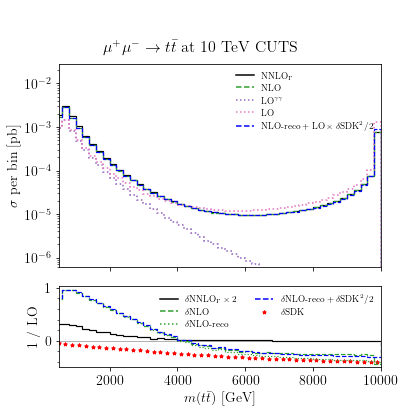

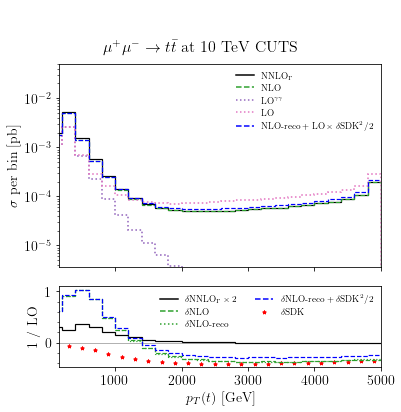

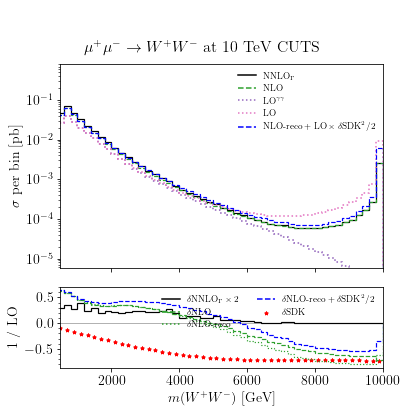

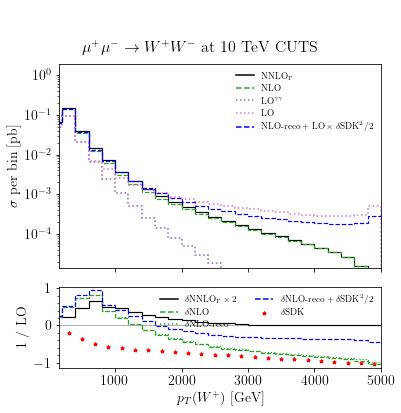

In [42]:
# observables and histograms, with sudakov


energies = [10]

observables = ['mtt', 'pttop']
#observables = ['mtt', ]
#observables = ['mtt', 'pttt', 'pttop']
#observables = ['top rap', 'tt rap']

#observables = ['mtt', ]
#observables = ['top rap', 'tt rap']

processes = ['tt', 'ww']
#processes = ['ww',]
#energies = [3]
allcolors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values()) + list(mcolors.XKCD_COLORS.values())
allcolors[1] = 'black'
allcolors[0] = 'blue'
allcolors[3] = 'red'


proc_string = {'tt': '$\\mu^+\\mu^- \\to t \\bar t$',
               'ww': '$\\mu^+\\mu^- \\to W^+ W^-$'}

lwdot = lw*1.3
cut = True
for p in processes:
    for en, cut in [(10,True)]:
        fname_mg = os.path.join(p, 'run_%dtev_NLO_mumtt_03permil_cuts' % en, 'MADatNLO.HwU')
        fname_mgnovi = os.path.join(p, 'run_%dtev_NLO_mumtt_03permil_novirt_cuts' % en, 'MADatNLO.HwU')
        fname_nnlo = os.path.join(p, 'run_nnlo%d_fixqp_mufmtt_cuts' % en, 'MADatNLO.HwU')
        fname_nnlo_scdn = os.path.join(p, 'run_nnlo%d_fixqp_mufmtt_mufact0.5_cuts' % en, 'MADatNLO.HwU')
        fname_nnlo_scup = os.path.join(p, 'run_nnlo%d_fixqp_mufmtt_mufact2.0_cuts' % en, 'MADatNLO.HwU')
        fname_sdk = os.path.join(p, 'run_sdk_%dtev_cuts' % en, 'MADatNLO.HwU')
        fname_sdkaa = os.path.join(p, 'run_sdkaa_%dtev_cuts' % en, 'MADatNLO.HwU')


        for o in observables:
        
            print(p, en, o, cut)
            scut = ''
            if cut:
                scut = 'C'
            try:
                # mg histograms
                h_lo_mg = get_histo_from_file(fname_mg, o, 'LO'+scut)
                h_loaa_mg = get_histo_from_file(fname_mg, o, 'LOAA'+scut)
                h_nlo_mgnovi = get_histo_from_file(fname_mgnovi, o, 'NLO'+scut)
                h_nlo_mg = get_histo_from_file(fname_mg, o, 'NLO'+scut)
                h_nlor_mg = get_histo_from_file(fname_mg, o, 'NLOR'+scut)
                h_tot_mg = get_histo_from_file(fname_mg, o, 'TOT'+scut)
                # nnlo histograms
                h_lo_nnlo = get_histo_from_file(fname_nnlo, o, 'LO'+scut, scvarfiles = [fname_nnlo_scdn, fname_nnlo_scup])
                h_nlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NLO'+scut, scvarfiles = [fname_nnlo_scdn, fname_nnlo_scup])
                h_nnlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NNLO'+scut, scvarfiles = [fname_nnlo_scdn, fname_nnlo_scup])
                
                h_tota = h_nnlo_nnlo + h_tot_mg
            except (FileNotFoundError, HistoNotFound) as e:
                print(e)
                continue

            h_sdk = get_histo_from_file(fname_sdk, o, 'SDKW'+scut)
            h_sdkaa = get_histo_from_file(fname_sdkaa, o, 'SDKW'+scut)
            h_sdk = h_sdk + h_sdkaa

            # now the figure
            fig, axes = plt.subplots(nrows = 2, ncols= 1, sharex = True, 
                                     gridspec_kw={'height_ratios': [2.5,1]})
            fig.set_size_inches(7*0.75,7*0.75)
            if cut:
                sscut = 'CUTS'
            else:
                sscut = 'NO CUTS'
            fig.suptitle("\n\n" + "    " + proc_string[p] + ' at %d TeV   %s' % (en, sscut), fontsize=16, y=1.08 ) 
            
            for ax in axes:
                pos = ax.get_position()
                ax.set_position([pos.x0, pos.y0, pos.width*1.1, pos.height*1.1])
                ax.yaxis.set_minor_locator(AutoMinorLocator())
            
            ttz_labels = {'tt': '$t\\bar t Z$', 'ww': '$W^+W^- Z$'}

            #main frame, show absolute xsec
            ax = axes[0]
            ax.set_ylabel("$\sigma$ per bin [pb]")
            ax.set_yscale('log')
            if o == 'mtt':
                obsrange = (0.,en*1000.)
            elif o in ['pttt', 'pttop']:
                obsrange = (0.,en*1000.)
            elif o in ['thetatt']:
                obsrange = (0.,math.pi)
            elif o in ['top rap', 'tt rap']:
                obsrange = (-12,12)
                
            if o == 'mtt' and p == 'tt':
                if cut:
                    ax.set_xlim(500,en*1000)
                else:
                    ax.set_xlim(340,en*1000)
            if o == 'mtt' and p == 'ww':
                ax.set_xlim(160,en*1000)
                if cut:
                    ax.set_xlim(500,en*1000)
                    
            if o in ['pttt', 'pttop']:
                ax.set_xlim(0,en*1000/2)
                if cut and o == 'pttop':
                    ax.set_xlim(150,en*1000/2)
            if o in ['thetatt']:
                ax.set_xlim(0,math.pi)
            if o in ['top rap', 'tt rap']:
                if cut:
                    ax.set_xlim(-2.6,2.6)
                else:
                    ax.set_xlim(-4.6,4.6)
                    if en == 3 and o == 'tt rap':
                        ax.set_xlim(-3.1,3.1)                    
                
            binwidth = (obsrange[1]-obsrange[0])/h_tota['nbins']
            # total
            ax.hist(x = h_tota['x'], weights = h_tota['y'], histtype= 'step', bins = h_tota['nbins'], 
                   label = '$\\textrm{NNLO}_{\\Gamma}$',
                   linewidth=lw, color=allcolors[1], range=obsrange)
            
            ax.hist(x = h_tot_mg['x'], weights = h_tot_mg['y'], histtype= 'step', bins = h_tot_mg['nbins'], 
                   label = '$\\textrm{NLO}$',
                   linewidth=lw, color=allcolors[2], linestyle='dashed', range=obsrange)
            
            if o == 'pttt':
                ax.hist(x = h_nlo_nnlo['x'], weights = h_nlo_nnlo['y'], histtype= 'step', bins = h_nlo_nnlo['nbins'], 
                   label = '$\\textrm{NLO}_{\\Gamma}$',
                   linewidth=lw, color=allcolors[15], linestyle='dashed', range=obsrange)
            
            ax.hist(x = h_loaa_mg['x'], weights = h_loaa_mg['y'], histtype= 'step', bins = h_loaa_mg['nbins'], 
                   label = '$\\textrm{LO}^{\\gamma\\gamma}$',
                   linewidth=lwdot, color=allcolors[4], linestyle='dotted', range=obsrange)
            
            ax.hist(x = h_lo_mg['x'], weights = h_lo_mg['y'], histtype= 'step', bins = h_lo_mg['nbins'], 
                   label = '$\\textrm{LO}$',
                   linewidth=lwdot, color=allcolors[6], range=obsrange, ls='dotted')
            ax.set_ylim(min([v for v in h_lo_mg['y'] if v > 0])/20, max(h_lo_mg['y'])*20)
            
            h_plot = h_lo_mg + h_nlor_mg + (h_sdk / h_lo_mg)*h_sdk*0.5
            ax.hist(x = h_plot['x'], weights = h_plot['y'], histtype= 'step', bins = h_plot['nbins'], 
                    label = '$\\textrm{NLO-reco}+\\textrm{LO}\\times\\delta{\\rm SDK}^2/2$', 
                    linewidth=lw, color='blue', linestyle='dashed',range=obsrange)      
            
            update_legend(ax, ncol=1, pos='auto')

            
            ax=axes[1]
            #  inset
            ax.set_ylabel("1 / $\\textrm{LO}$")
            ax.hist(x = h_lo_mg['x'], weights = [0]*h_lo_mg['nbins'], histtype= 'step', bins = h_lo_mg['nbins'], 
                   linewidth=lw/2, color='gray', linestyle='solid', range=obsrange)        
            
            nnlo_rescale = 2
            h_kfac = h_nnlo_nnlo / h_lo_mg * nnlo_rescale
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[1], linestyle='solid', 
                    label = '$\\delta\\textrm{NNLO}_{\\Gamma} \\times %d$' % nnlo_rescale, range=obsrange)  

            h_kfac = h_nlo_mg / h_lo_mg
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[2], linestyle='dashed', 
                    label = '$\\delta\\textrm{NLO}$', range=obsrange)
            
            #h_kfac = h_nlo_mgnovi / h_lo_mg
            #ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
            #       linewidth=lw, color=allcolors[3], linestyle='dashed', 
            #        label = '$\\delta\\textrm{NLO-no}V$', range=obsrange)            
            
            h_kfac = h_sdk / h_lo_mg
            #ax.hist(x=h_kfac['x'], weights=h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'],
            #         linewidth=lw, color=allcolors[19], linestyle='solid',
            #        label ='$\\delta$SDK', range=obsrange)           
            ax.scatter(h_kfac['x'], h_kfac['y'], marker = '*', color = 'red', s = 13,
                   label='$\\delta$SDK')
            
            h_kfac = h_nlor_mg / h_lo_mg
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[2], linestyle='dotted', 
                    label = '$\\delta\\textrm{NLO-reco}$', range=obsrange)
                        
            h_kfac = (h_nlor_mg/h_lo_mg) + (h_sdk / h_lo_mg)*(h_sdk/h_lo_mg)*0.5 
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color='blue', linestyle='dashed', 
                    label = '$\\delta\\textrm{NLO-reco}+\\delta{\\rm SDK}^2/2$', range=obsrange)
            
            
            #h_kfac = (h_nlo_mg - h_nlo_mgnovi) / h_lo_mg
            #ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
            #       linewidth=lw, color='blue', linestyle='dashed', 
            #        label = '$\\delta\\textrm{NLO} - \\delta\\textrm{NLO-no}V$', range=obsrange)          
            
            update_legend(ax, ncol=2, pos='auto')

            ax.set_xlabel('%s' % xlabels[p][o])
            
            plt.savefig('pheno_sudakov_%s%s_%s_%dtev.pdf' % (o.replace(' ',''),scut,p,en), bbox_inches = 'tight')

20
42
100
20
42
100


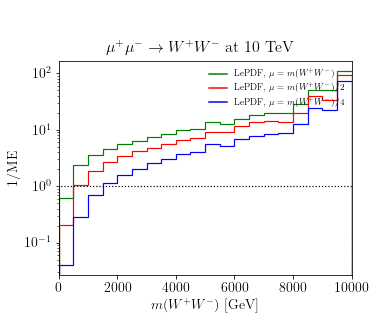

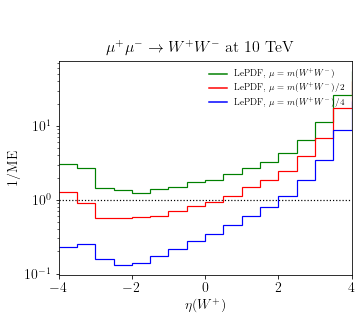

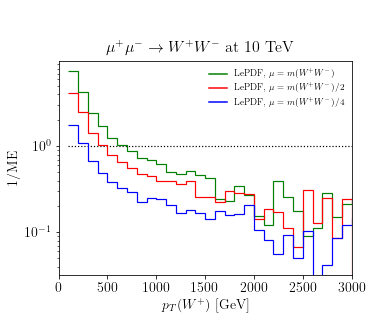

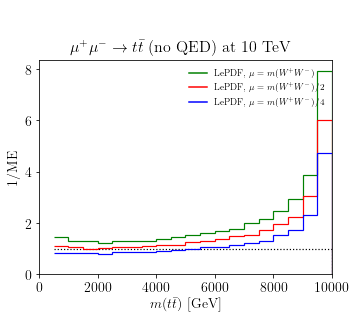

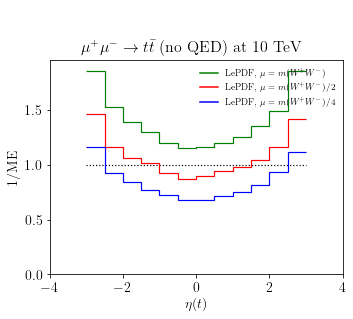

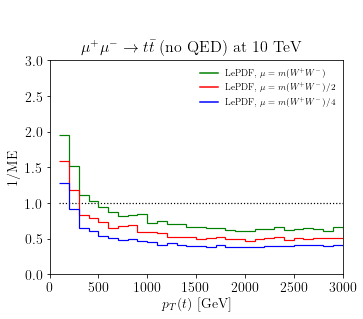

In [35]:
# plots by davide, EWA/PDF vs Matrix element
###
pjoin = os.path.join
nrebin = 10
en = 10




        
xlabels = {'tt': {'mtt': '$m(t\\bar t)$ [GeV]',
                  'ptt': '$p_T(t)$ [GeV]',
                  'etat': '$\\eta(t)$',},
           'ww': {'mWW': '$m(W^+W^-)$ [GeV]',
                  'ptW': '$p_T(W^+)$ [GeV]',
                  'etaW': '$\\eta(W^+)$'}}

p='ww'
path = "../Davide2025/Notebooks/PlotDistr/WW_WW/10TeVolnlyptcut_datforMarco"
for o in ['mWW', 'etaW', 'ptW']:
    
    if o == 'etaW':
        nrebin = 1
    elif o =='mWW':
        nrebin = 50
    else:
        nrebin = 10
    file_me = pjoin(path, '%s.dat' % o)
    file_pdf = pjoin(path, '%smuLePDF.dat' % o)
    file_pdfo2 = pjoin(path, '%smuhalfLePDF.dat' % o)
    file_pdfo4 = pjoin(path, '%smuquarterLePDF.dat' % o)
    
    if o == 'mWW':
        obsrange = (0.,en*1000.)
    elif o in ['ptW',]:
        obsrange = (0.,en*1000.)
    elif o in ['etaW']:
        obsrange = (-10.5,10.5)
    
    h_me = get_histo_from_file_dp(file_me, nrebin, obsrange)
    h_pdf = get_histo_from_file_dp(file_pdf, nrebin, obsrange)
    h_pdfo2 = get_histo_from_file_dp(file_pdfo2, nrebin, obsrange)
    h_pdfo4 = get_histo_from_file_dp(file_pdfo4, nrebin, obsrange)

    fig, ax = plt.subplots(nrows = 1, ncols= 1, sharex = True)
    fig.set_size_inches(7*0.75,7*0.75**2)

    fig.suptitle("\n\n" + "    " + proc_string[p] + ' at %d TeV' % en, fontsize=16, y=1.07 ) 

    if o == 'mWW':
        ax.set_xlim(0,10000)
    elif o in ['ptW',]:
        ax.set_xlim(0,3000)
    elif o in ['etaW']:
        ax.set_xlim(-4, 4)
        
    ax.set_ylabel('1/ME')
    ax.set_yscale('log')
            
    hratio = h_me / h_me
    ax.hist(x = hratio['x'], weights = hratio['y'], histtype= 'step', bins = hratio['nbins'],
                   linewidth=lw, color='black', range=obsrange, ls='dotted')
    
    hratio = h_pdf / h_me
    ax.hist(x = hratio['x'], weights = hratio['y'], histtype= 'step', bins = hratio['nbins'],
            label = 'LePDF, $\\mu=m(W^+W^-)$',
                   linewidth=lw, color='green', range=obsrange)
    
    hratio = h_pdfo2 / h_me
    ax.hist(x = hratio['x'], weights = hratio['y'], histtype= 'step', bins = hratio['nbins'],
            label = 'LePDF, $\\mu=m(W^+W^-)/2$',
                   linewidth=lw, color='red', range=obsrange)

    hratio = h_pdfo4 / h_me
    ax.hist(x = hratio['x'], weights = hratio['y'], histtype= 'step', bins = hratio['nbins'],
            label = 'LePDF, $\\mu=m(W^+W^-)/4$',
                   linewidth=lw, color='blue', range=obsrange)
    print(h_me['nbins'])
    update_legend(ax,1, pos='auto')
    ax.set_xlabel(xlabels[p][o])
    
    plt.savefig('mevspdf_ww_%s.pdf' % (o), bbox_inches = 'tight')
    
    
    
p='tt'
path="../Davide2025/Notebooks/PlotDistr/ZZ_tt/10TeVcuts_datforMarco"
for o in ['mtt', 'etat', 'ptt']:
    
    if o == 'etat':
        nrebin = 1
    elif o =='mtt':
        nrebin = 50
    else:
        nrebin = 10
        
    if o == 'etat':
        file_me = pjoin(path, 'beforebias', '%snoQED.dat' % o)
        file_pdf = pjoin(path, 'beforebias', '%smuLePDF.dat' % o)
        file_pdfo2 = pjoin(path, 'beforebias', '%smuhalfLePDF.dat' % o)
        file_pdfo4 = pjoin(path, 'beforebias', '%smuquarterLePDF.dat' % o)
    
    elif o == 'mtt':
        file_me = pjoin(path, 'biasmtt', '%snoQED.dat' % o)
        file_pdf = pjoin(path, 'biasmtt', '%smuLePDF.dat' % o)
        file_pdfo2 = pjoin(path, 'biasmtt', '%smuhalfLePDF.dat' % o)
        file_pdfo4 = pjoin(path, 'biasmtt', '%smuquarterLePDF.dat' % o)
    
    elif o == 'ptt':
        file_me = pjoin(path, 'biaspt', '%snoQED.dat' % o)
        file_pdf = pjoin(path, 'biaspt', '%smuLePDF.dat' % o)
        file_pdfo2 = pjoin(path, 'biaspt', '%smuhalfLePDF.dat' % o)
        file_pdfo4 = pjoin(path, 'biaspt', '%smuquarterLePDF.dat' % o)
    
    if o == 'mtt':
        obsrange = (0.,en*1000.)
    elif o in ['ptt',]:
        obsrange = (0.,en*1000.)
    elif o in ['etat']:
        obsrange = (-10.5,10.5)
    
    h_me = get_histo_from_file_dp(file_me, nrebin, obsrange)
    h_pdf = get_histo_from_file_dp(file_pdf, nrebin, obsrange)
    h_pdfo2 = get_histo_from_file_dp(file_pdfo2, nrebin, obsrange)
    h_pdfo4 = get_histo_from_file_dp(file_pdfo4, nrebin, obsrange)
    
    #h_me_bmtt = get_histo_from_file_dp(file_me_bmtt, nrebin, obsrange)
    #h_pdf_bmtt = get_histo_from_file_dp(file_pdf_bmtt, nrebin, obsrange)
    #h_pdfo2_bmtt = get_histo_from_file_dp(file_pdfo2_bmtt, nrebin, obsrange)
    #h_pdfo4_bmtt = get_histo_from_file_dp(file_pdfo4_bmtt, nrebin, obsrange)
    
    #h_me_bptt = get_histo_from_file_dp(file_me_bptt, nrebin, obsrange)
    #h_pdf_bptt = get_histo_from_file_dp(file_pdf_bptt, nrebin, obsrange)
    #h_pdfo2_bptt = get_histo_from_file_dp(file_pdfo2_bptt, nrebin, obsrange)
    #h_pdfo4_bptt = get_histo_from_file_dp(file_pdfo4_bptt, nrebin, obsrange)

    fig, ax = plt.subplots(nrows = 1, ncols= 1, sharex = True)
    fig.set_size_inches(7*0.75,7*0.75**2)

    fig.suptitle("\n\n" + "    " + proc_string[p] + ' (no QED)'+ ' at %d TeV' % en, fontsize=16, y=1.07 ) 

    if o == 'mtt':
        ax.set_xlim(0,10000)
    elif o in ['ptt',]:
        ax.set_xlim(0,3000)
    elif o in ['etat']:
        ax.set_xlim(-4, 4)
        
    ax.set_ylabel('1/ME')
    #ax.set_yscale('log')
    hratio = h_me / h_me
    ax.hist(x = hratio['x'], weights = hratio['y'], histtype= 'step', bins = hratio['nbins'],
                   linewidth=lw, color='black', range=obsrange, ls='dotted')

    hratio = h_pdf / h_me
    ax.hist(x = hratio['x'], weights = hratio['y'], histtype= 'step', bins = hratio['nbins'],
            label = 'LePDF, $\\mu=m(W^+W^-)$',
                   linewidth=lw, color='green', range=obsrange)
    
    hratio = h_pdfo2 / h_me
    ax.hist(x = hratio['x'], weights = hratio['y'], histtype= 'step', bins = hratio['nbins'],
            label = 'LePDF, $\\mu=m(W^+W^-)/2$',
                   linewidth=lw, color='red', range=obsrange)

    hratio = h_pdfo4 / h_me
    ax.hist(x = hratio['x'], weights = hratio['y'], histtype= 'step', bins = hratio['nbins'],
            label = 'LePDF, $\\mu=m(W^+W^-)/4$',
                   linewidth=lw, color='blue', range=obsrange)
    

    #hratio = h_pdf_bmtt / h_me_bmtt
    #ax.hist(x = hratio['x'], weights = hratio['y'], histtype= 'step', bins = hratio['nbins'],
    #        label = 'LePDF, $\\mu=m(W^+W^-)$, bias mtt',
    #               linewidth=lw, color='green', range=obsrange, linestyle= 'dashed')
    #
    #hratio = h_pdfo2_bmtt / h_me_bmtt
    #ax.hist(x = hratio['x'], weights = hratio['y'], histtype= 'step', bins = hratio['nbins'],
    #        label = 'LePDF, $\\mu=m(W^+W^-)/2$, bias mtt',
    #               linewidth=lw, color='red', range=obsrange, linestyle= 'dashed')

    #hratio = h_pdfo4_bmtt / h_me_bmtt
    #ax.hist(x = hratio['x'], weights = hratio['y'], histtype= 'step', bins = hratio['nbins'],
    #        label = 'LePDF, $\\mu=m(W^+W^-)/4$, bias mtt',
    #               linewidth=lw, color='blue', range=obsrange, linestyle= 'dashed')    
    
    

    #hratio = h_pdf_bptt / h_me_bptt
    #ax.hist(x = hratio['x'], weights = hratio['y'], histtype= 'step', bins = hratio['nbins'],
    #        label = 'LePDF, $\\mu=m(W^+W^-)$, bias ptt',
    #               linewidth=lw, color='green', range=obsrange, linestyle= 'dotted')
    
    #hratio = h_pdfo2_bptt / h_me_bptt
    #ax.hist(x = hratio['x'], weights = hratio['y'], histtype= 'step', bins = hratio['nbins'],
    #        label = 'LePDF, $\\mu=m(W^+W^-)/2$, bias ptt',
    #               linewidth=lw, color='red', range=obsrange, linestyle= 'dotted')

    #hratio = h_pdfo4_bptt / h_me_bptt
    #ax.hist(x = hratio['x'], weights = hratio['y'], histtype= 'step', bins = hratio['nbins'],
    #        label = 'LePDF, $\\mu=m(W^+W^-)/4$, bias ptt',
    #               linewidth=lw, color='blue', range=obsrange, linestyle= 'dotted')  
    
    print(h_me['nbins'])
    update_legend(ax,1, pos='auto')
    if o == 'ptt':
        ax.set_ylim(0,3)
    ax.set_xlabel(xlabels[p][o])
    
    plt.savefig('mevspdf_tt_%s.pdf' % (o), bbox_inches = 'tight')

###### 